In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
from mpl_toolkits.mplot3d import Axes3D
from lifetimes import BetaGeoFitter

#### CARREGANDO BASE DE DADOS

In [67]:
# Suprimir warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Carregar as bases de dados
base_analise_path = 'Base_analise.csv'
base_itens_path = 'Base_itens.csv'
base_analise_original = pd.read_csv(base_analise_path, sep='|')
base_itens_original = pd.read_csv(base_itens_path, sep='|')

# Verificar os nomes das colunas antes da mesclagem
print("Colunas da base_analise:", base_analise_original.columns)
print("Colunas da base_itens:", base_itens_original.columns)


# Verificar dados antes do merge
print("\nBase Análise - números únicos:", len(base_analise_original['numero'].unique()))
print("Base Itens - números únicos:", len(base_itens_original['numero'].unique()))
print("Base analise original:", len(base_analise_original))

Colunas da base_analise: Index(['situacao', 'base_vencimento', 'numero', 'observacao_cliente',
       'tipo_desconto_acrescimo', 'forma_pagamento', 'transportadora_contato',
       'ultima_alteracao', 'observacao_representada', 'id', 'emissao',
       'faturamento', 'tipo_frete', 'id_cond_pagto', 'excluido',
       'id_tabela_preco', 'itens', 'id_vendedor', 'id_cliente', 'ordem_compra',
       'id_parceiro', 'transportadora', 'previsao_entrega', 'valor_frete',
       'condicao_pagamento', 'valor_desconto_acrescimo', 'status'],
      dtype='object')
Colunas da base_itens: Index(['excluido', 'preco_bruto', 'observacao', 'ultima_alteracao',
       'qtd_embalagem', 'percentual_desconto_acrescimo', 'embalagem',
       'preco_liquido', 'grades', 'preco_custo', 'id_produto', 'quantidade',
       'emissao', 'numero', 'id', 'id_vendedor', 'id_cliente',
       'valor_desconto_acrescimo', 'status'],
      dtype='object')

Base Análise - números únicos: 21366
Base Itens - números únicos: 21360
Bas

/var/folders/8y/5ndc5qwd1b38zpft_5ptb5280000gq/T/ipykernel_26869/2724972856.py:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  base_itens_original = pd.read_csv(base_itens_path, sep='|')


#### PRÉ-PROCESSAMENTO

In [68]:
base_analise = base_analise_original
base_itens = base_itens_original
# Converter campo numero para string em ambas as bases
base_analise['numero'] = base_analise['numero'].astype(str)
base_itens['numero'] = base_itens['numero'].astype(str)

# Remover a coluna 'itens' da base_analise
if 'itens' in base_analise.columns:
    base_analise = base_analise.drop('itens', axis=1)

base_analise = base_analise[base_analise['status'] == 'pedido']
base_itens = base_itens[base_itens['status'] == 'pedido']
base_itens = base_itens[base_itens['excluido'] == False]

# Realizar o merge
merged_data = pd.merge(base_analise, base_itens, on='numero', suffixes=('_analise', '_itens'))

# Verificar dados após o merge
print("\nMerged Data - primeiros números:", merged_data['numero'].head())
print("Merged Data - números únicos:", len(merged_data['numero'].unique()))

# Salvar apenas se houver dados válidos
if not merged_data['numero'].isna().all():
    #merged_data.to_csv('base_mesclada.csv', sep='|', index=False)
    print("\nBase mesclada salva com sucesso!")
else:
    print("\nERRO: Campo 'numero' está vazio após o merge!")

# Verificar os nomes das colunas após a mesclagem
print("Colunas do merged_data:", merged_data.columns)

# Converter a coluna 'emissao' para formato datetime
merged_data['emissao_analise'] = pd.to_datetime(merged_data['emissao_analise'])

print("Pedidos")
print(len(base_analise))


Merged Data - primeiros números: 0     9.0
1     9.0
2    17.0
3    17.0
4    17.0
Name: numero, dtype: object
Merged Data - números únicos: 14041

Base mesclada salva com sucesso!
Colunas do merged_data: Index(['situacao', 'base_vencimento', 'numero', 'observacao_cliente',
       'tipo_desconto_acrescimo', 'forma_pagamento', 'transportadora_contato',
       'ultima_alteracao_analise', 'observacao_representada', 'id_analise',
       'emissao_analise', 'faturamento', 'tipo_frete', 'id_cond_pagto',
       'excluido_analise', 'id_tabela_preco', 'id_vendedor_analise',
       'id_cliente_analise', 'ordem_compra', 'id_parceiro', 'transportadora',
       'previsao_entrega', 'valor_frete', 'condicao_pagamento',
       'valor_desconto_acrescimo_analise', 'status_analise', 'excluido_itens',
       'preco_bruto', 'observacao', 'ultima_alteracao_itens', 'qtd_embalagem',
       'percentual_desconto_acrescimo', 'embalagem', 'preco_liquido', 'grades',
       'preco_custo', 'id_produto', 'quantidade'

#### CALCULO RFMA

In [69]:
# Recency: Número de dias desde a última compra
data_referencia = merged_data['emissao_analise'].max()
recency = merged_data.groupby('id_cliente_analise')['emissao_analise'].max().apply(lambda x: (data_referencia - x).days)

# Frequency: Número de pedidos únicos por cliente
frequency = merged_data.groupby('id_cliente_analise')['numero'].nunique()

# Monetary: Valor total gasto
merged_data['valor_total'] = merged_data['preco_liquido'] * merged_data['quantidade']
monetary = merged_data.groupby('id_cliente_analise')['valor_total'].sum()

# Age (Antiguidade): Dias desde a primeira compra
age = merged_data.groupby('id_cliente_analise')['emissao_analise'].min().apply(lambda x: (data_referencia - x).days)

# Combinar métricas em um único DataFrame
rfma = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary,
    'Age': age
})

# Resetar o índice para ter id_cliente como coluna
rfma = rfma.reset_index()

# Adicionar algumas verificações
print("\nEstatísticas das métricas RFMA:")
print("\nRecency (dias):")
print(rfma['Recency'].describe())
print("\nFrequency (número de pedidos):")
print(rfma['Frequency'].describe())
print("\nMonetary (valor total):")
print(rfma['Monetary'].describe())
print("\nAge (dias desde primeira compra):")
print(rfma['Age'].describe())

# # Salvar o resultado em um arquivo CSV
# rfma.to_csv('RFMA_por_cliente.csv', index=False)

# Exibir o DataFrame RFMA
print("\nPrimeiras linhas do RFMA:")
print(rfma.head())

# Verificações adicionais
print("\nContagens de controle:")
print(f"Número total de clientes: {len(rfma)}")

# Verificação adicional para Age
print("\nVerificação de coerência:")
print("Clientes com Age menor que Recency:", len(rfma[rfma['Age'] < rfma['Recency']]))


Estatísticas das métricas RFMA:

Recency (dias):
count    1064.000000
mean      688.637218
std       586.826499
min         0.000000
25%        43.750000
50%       680.500000
75%      1257.000000
max      1627.000000
Name: Recency, dtype: float64

Frequency (número de pedidos):
count    1064.000000
mean       13.200188
std        27.509416
min         1.000000
25%         1.000000
50%         3.000000
75%        14.000000
max       266.000000
Name: Frequency, dtype: float64

Monetary (valor total):
count      1064.000000
mean      10368.853562
std       28849.227215
min           3.990000
25%         120.000000
50%         942.075000
75%        6614.990000
max      387255.780000
Name: Monetary, dtype: float64

Age (dias desde primeira compra):
count    1064.000000
mean     1002.457707
std       485.116355
min         4.000000
25%       572.750000
50%      1150.000000
75%      1414.250000
max      1631.000000
Name: Age, dtype: float64

Primeiras linhas do RFMA:
   id_cliente_analise  R

#### GRÁFICOS RFMA INICIAIS

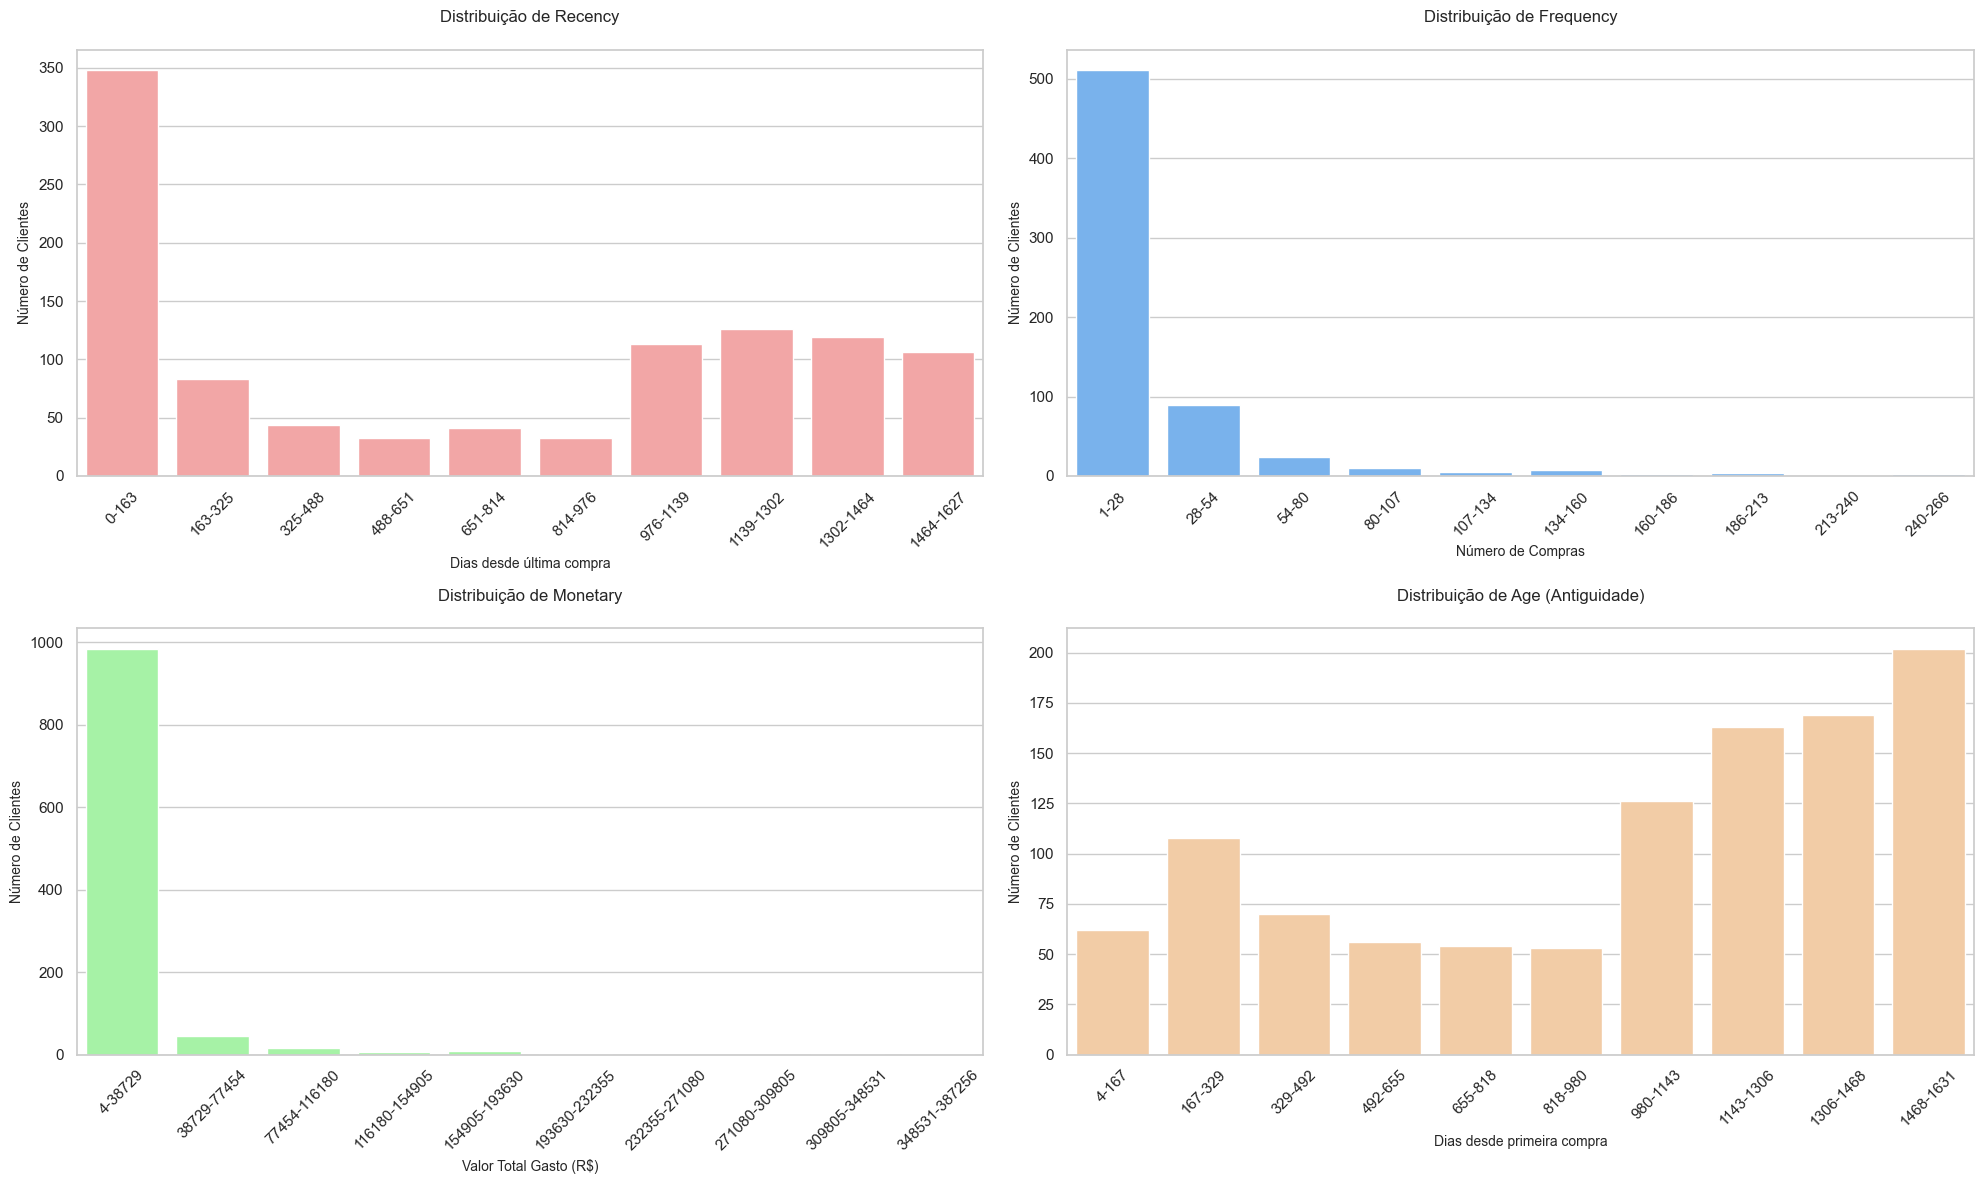


Distribuição de clientes por faixa:

Recency (dias):
R_range
0-163        348
163-325       83
325-488       44
488-651       33
651-814       41
814-976       33
976-1139     113
1139-1302    126
1302-1464    119
1464-1627    106
Name: count, dtype: int64

Frequency (compras):
F_range
1-28       511
28-54       90
54-80       24
80-107      10
107-134      5
134-160      8
160-186      2
186-213      4
213-240      0
240-266      2
Name: count, dtype: int64

Monetary (R$):
M_range
4-38729          984
38729-77454       46
77454-116180      16
116180-154905      6
154905-193630      8
193630-232355      1
232355-271080      0
271080-309805      0
309805-348531      1
348531-387256      1
Name: count, dtype: int64

Age (dias desde primeira compra):
A_range
4-167         62
167-329      108
329-492       70
492-655       56
655-818       54
818-980       53
980-1143     126
1143-1306    163
1306-1468    169
1468-1631    202
Name: count, dtype: int64


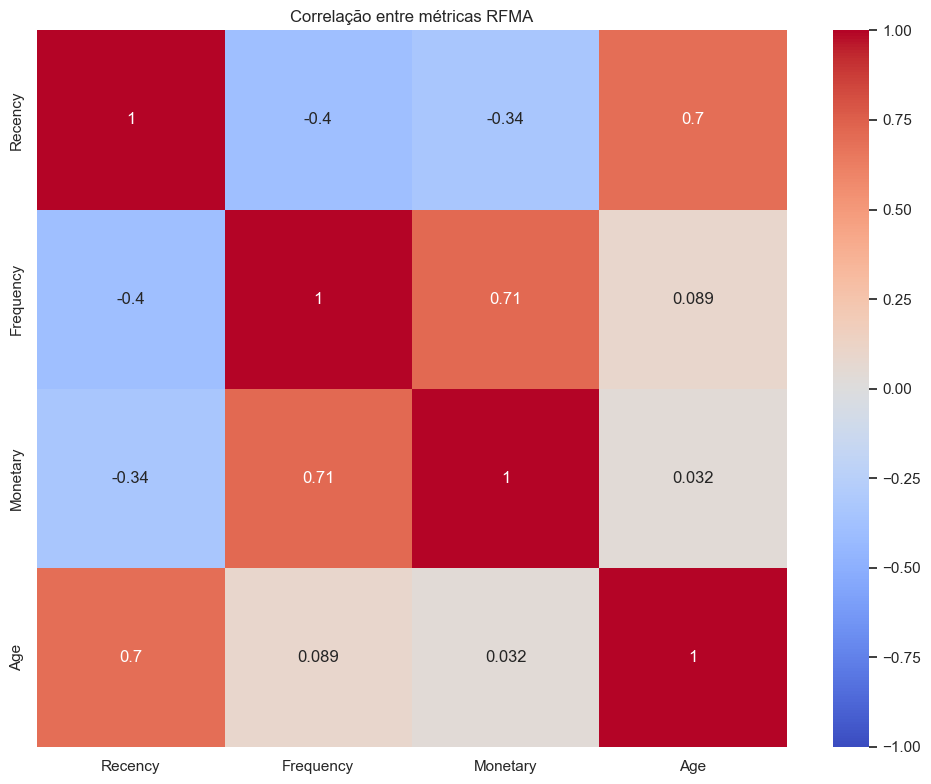

In [70]:
# Configuração básica do seaborn
sns.set(style="whitegrid")

# Criar bins e labels para cada métrica
def create_range_labels(data, bins):
    labels = []
    for i in range(len(bins)-1):
        labels.append(f'{bins[i]:.0f}-{bins[i+1]:.0f}')
    return labels

# Definir uma paleta de cores atraente
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

# Recency
r_bins = np.linspace(rfma['Recency'].min(), rfma['Recency'].max(), 11)
r_labels = create_range_labels(rfma['Recency'], r_bins)
rfma['R_range'] = pd.cut(rfma['Recency'], bins=r_bins, labels=r_labels)

# Frequency
f_bins = np.linspace(rfma['Frequency'].min(), rfma['Frequency'].max(), 11)
f_labels = create_range_labels(rfma['Frequency'], f_bins)
rfma['F_range'] = pd.cut(rfma['Frequency'], bins=f_bins, labels=f_labels)

# Monetary
m_bins = np.linspace(rfma['Monetary'].min(), rfma['Monetary'].max(), 11)
m_labels = create_range_labels(rfma['Monetary'], m_bins)
rfma['M_range'] = pd.cut(rfma['Monetary'], bins=m_bins, labels=m_labels)

# Age (Antiguidade)
a_bins = np.linspace(rfma['Age'].min(), rfma['Age'].max(), 11)
a_labels = create_range_labels(rfma['Age'], a_bins)
rfma['A_range'] = pd.cut(rfma['Age'], bins=a_bins, labels=a_labels)

# Criar gráficos
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Gráfico de Recency
r_counts = rfma['R_range'].value_counts().sort_index()
sns.barplot(x=r_counts.index, y=r_counts.values, ax=axes[0,0], color=colors[0])
axes[0,0].set_title('Distribuição de Recency', fontsize=12, pad=20)
axes[0,0].set_xlabel('Dias desde última compra', fontsize=10)
axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico de Frequency
f_counts = rfma['F_range'].value_counts().sort_index()
sns.barplot(x=f_counts.index, y=f_counts.values, ax=axes[0,1], color=colors[1])
axes[0,1].set_title('Distribuição de Frequency', fontsize=12, pad=20)
axes[0,1].set_xlabel('Número de Compras', fontsize=10)
axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico de Monetary
m_counts = rfma['M_range'].value_counts().sort_index()
sns.barplot(x=m_counts.index, y=m_counts.values, ax=axes[1,0], color=colors[2])
axes[1,0].set_title('Distribuição de Monetary', fontsize=12, pad=20)
axes[1,0].set_xlabel('Valor Total Gasto (R$)', fontsize=10)
axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico de Age (Antiguidade)
a_counts = rfma['A_range'].value_counts().sort_index()
sns.barplot(x=a_counts.index, y=a_counts.values, ax=axes[1,1], color=colors[3])
axes[1,1].set_title('Distribuição de Age (Antiguidade)', fontsize=12, pad=20)
axes[1,1].set_xlabel('Dias desde primeira compra', fontsize=10)
axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=45)

# Ajustar o layout
plt.tight_layout()
plt.show()

# Imprimir distribuição
print("\nDistribuição de clientes por faixa:")
print("\nRecency (dias):")
print(r_counts)
print("\nFrequency (compras):")
print(f_counts)
print("\nMonetary (R$):")
print(m_counts)
print("\nAge (dias desde primeira compra):")
print(a_counts)

# Análises adicionais de correlação
correlation_matrix = rfma[['Recency', 'Frequency', 'Monetary', 'Age']].corr()

# Plotar mapa de calor das correlações
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlação entre métricas RFMA')
plt.tight_layout()
plt.show()

#### ANÁLISE DE RETENÇÃO MENSAL

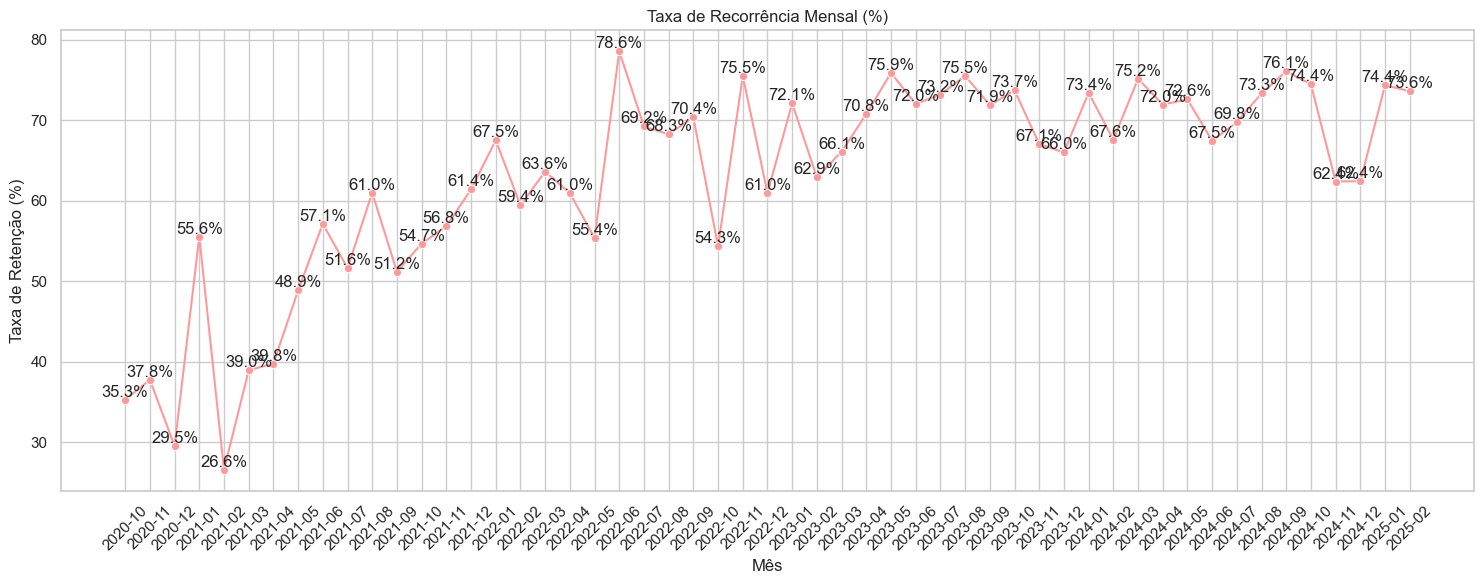


Resultados salvos em metricas_recorrencia_mensal.xlsx

Métricas de Recorrência:
yearmonth  retained_customers  prev_total_customers  retention_rate
  2020-10                  18                    51       35.294118
  2020-11                  17                    45       37.777778
  2020-12                  13                    44       29.545455
  2021-01                  20                    36       55.555556
  2021-02                  25                    94       26.595745
  2021-03                  30                    77       38.961039
  2021-04                  37                    93       39.784946
  2021-05                  43                    88       48.863636
  2021-06                  52                    91       57.142857
  2021-07                  63                   122       51.639344
  2021-08                  61                   100       61.000000
  2021-09                  64                   125       51.200000
  2021-10                  70      

In [71]:
# Criar um DataFrame com mês e cliente
monthly_customers = merged_data.groupby([merged_data['emissao_analise'].dt.strftime('%Y-%m'), 'id_cliente_analise']).size().reset_index()
monthly_customers.columns = ['yearmonth', 'id_cliente_analise', 'count']

# Criar um pivot para facilitar a comparação entre meses
customer_matrix = monthly_customers.pivot_table(
    index='id_cliente_analise',
    columns='yearmonth',
    values='count',
    fill_value=0
).astype(bool).astype(int)

# Calcular retenção
retention_rates = []
months = sorted(customer_matrix.columns)

for i in range(1, len(months)):
    prev_month = months[i-1]
    current_month = months[i]
    
    # Total de clientes no mês anterior
    prev_customers = customer_matrix[prev_month].sum()
    
    # Clientes que permaneceram
    retained = ((customer_matrix[prev_month] == 1) & (customer_matrix[current_month] == 1)).sum()
    
    # Calcular taxa
    retention_rate = (retained / prev_customers * 100) if prev_customers > 0 else 0
    
    retention_rates.append({
        'yearmonth': current_month,
        'retained_customers': retained,
        'prev_total_customers': prev_customers,
        'retention_rate': retention_rate
    })

retention_metrics = pd.DataFrame(retention_rates)

# Visualizar resultado
plt.figure(figsize=(15, 6))
sns.lineplot(data=retention_metrics, x='yearmonth', y='retention_rate', marker='o', color='#FF9999')
plt.title('Taxa de Recorrência Mensal (%)')
plt.xlabel('Mês')
plt.ylabel('Taxa de Retenção (%)')
plt.xticks(rotation=45)

# Adicionar valores sobre os pontos
for i, v in enumerate(retention_metrics['retention_rate']):
    if pd.notnull(v) and v != 0:
        plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Salvar resultados
retention_metrics.to_excel('metricas_recorrencia_mensal.xlsx', index=False)
print("\nResultados salvos em metricas_recorrencia_mensal.xlsx")

# Imprimir métricas
print("\nMétricas de Recorrência:")
print(retention_metrics.to_string(index=False))


# Estatísticas resumidas
print("\nEstatísticas de Recorrência:")
print(f"Taxa média de retenção: {retention_metrics['retention_rate'].mean():.1f}%")
print(f"Taxa máxima de retenção: {retention_metrics['retention_rate'].max():.1f}%")
print(f"Taxa mínima de retenção: {retention_metrics['retention_rate'].min():.1f}%")

#### ANÁLISE DE RETENÇÃO TRIMESTRAL

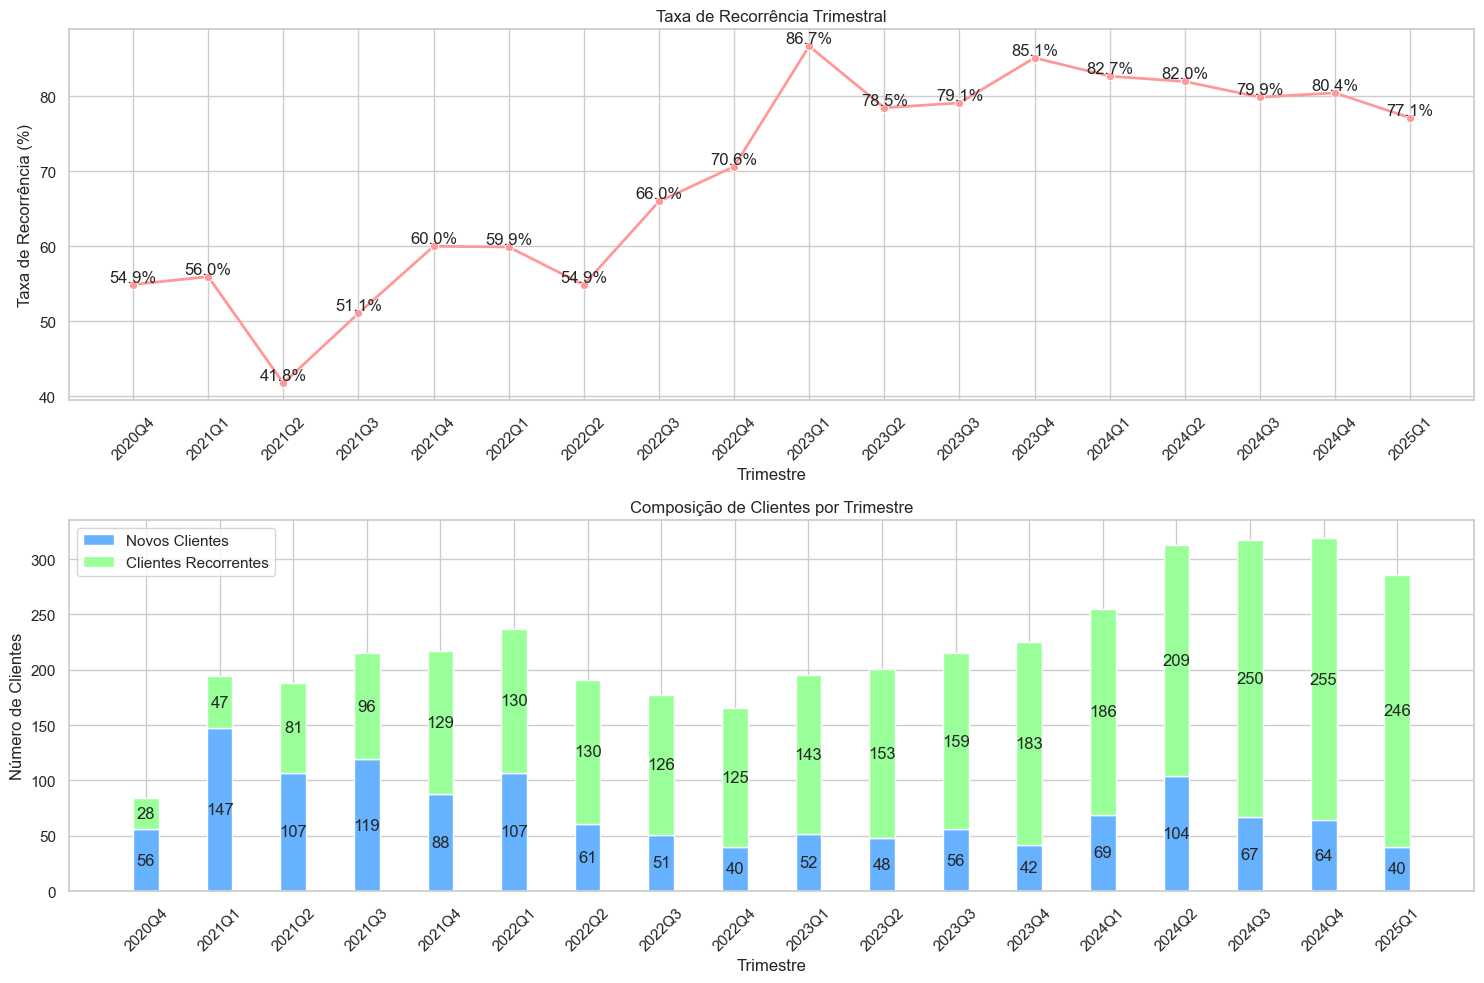


Resultados salvos em metricas_recorrencia_trimestral.xlsx

Métricas Trimestrais:
trimestre  total_customers  returning_customers  new_customers  recurrence_rate
   2020Q4               84                   28             56        54.901961
   2021Q1              194                   47            147        55.952381
   2021Q2              188                   81            107        41.752577
   2021Q3              215                   96            119        51.063830
   2021Q4              217                  129             88        60.000000
   2022Q1              237                  130            107        59.907834
   2022Q2              191                  130             61        54.852321
   2022Q3              177                  126             51        65.968586
   2022Q4              165                  125             40        70.621469
   2023Q1              195                  143             52        86.666667
   2023Q2              201            

In [72]:
# Criar trimestre para cada compra
merged_data['trimestre'] = merged_data['emissao_analise'].dt.to_period('Q')

# Criar DataFrame de clientes por trimestre
quarterly_customers = merged_data.groupby(['trimestre', 'id_cliente_analise']).size().reset_index()
quarterly_customers.columns = ['trimestre', 'id_cliente_analise', 'count']

# Criar pivot para análise trimestral
customer_matrix = quarterly_customers.pivot_table(
    index='id_cliente_analise',
    columns='trimestre',
    values='count',
    fill_value=0
).astype(bool).astype(int)

# Calcular recorrência trimestral
quarterly_metrics = []
quarters = sorted(customer_matrix.columns)

for i in range(1, len(quarters)):
    current_quarter = quarters[i]
    prev_quarter = quarters[i-1]
    
    # Total de clientes no trimestre anterior
    prev_customers = customer_matrix[prev_quarter].sum()
    
    # Clientes que voltaram
    returning = ((customer_matrix[prev_quarter] == 1) & (customer_matrix[current_quarter] == 1)).sum()
    
    # Novos clientes (não compraram no trimestre anterior)
    new_customers = (customer_matrix[current_quarter] & ~customer_matrix[prev_quarter]).sum()
    
    # Total de clientes no trimestre atual
    total_customers = customer_matrix[current_quarter].sum()
    
    # Calcular taxas
    recurrence_rate = (returning / prev_customers * 100) if prev_customers > 0 else 0
    
    quarterly_metrics.append({
        'trimestre': str(current_quarter),  # Convertendo para string
        'trimestre_obj': current_quarter,   # Mantendo o objeto período para ordenação
        'total_customers': total_customers,
        'returning_customers': returning,
        'new_customers': new_customers,
        'recurrence_rate': recurrence_rate
    })

quarterly_df = pd.DataFrame(quarterly_metrics)
quarterly_df = quarterly_df.sort_values('trimestre_obj')  # Ordenar pelos trimestres

# Visualizações
plt.figure(figsize=(15, 10))

# Gráfico 1: Taxa de Recorrência
plt.subplot(2, 1, 1)
sns.lineplot(data=quarterly_df, x='trimestre', y='recurrence_rate', marker='o', color='#FF9999', linewidth=2)
plt.title('Taxa de Recorrência Trimestral')
plt.xlabel('Trimestre')
plt.ylabel('Taxa de Recorrência (%)')
plt.xticks(rotation=45)

# Adicionar valores sobre os pontos
for i, row in enumerate(quarterly_df.itertuples()):
    if pd.notnull(row.recurrence_rate) and row.recurrence_rate != 0:
        plt.text(i, row.recurrence_rate, f'{row.recurrence_rate:.1f}%', ha='center', va='bottom')

# Gráfico 2: Composição de Clientes por Trimestre
plt.subplot(2, 1, 2)
width = 0.35
x = range(len(quarterly_df))

plt.bar(x, quarterly_df['new_customers'], width, label='Novos Clientes', color='#66B2FF')
plt.bar(x, quarterly_df['returning_customers'], width, bottom=quarterly_df['new_customers'],
        label='Clientes Recorrentes', color='#99FF99')

plt.xlabel('Trimestre')
plt.ylabel('Número de Clientes')
plt.title('Composição de Clientes por Trimestre')
plt.xticks(x, quarterly_df['trimestre'], rotation=45)
plt.legend()

# Adicionar valores nas barras
for i in range(len(quarterly_df)):
    # Valor para novos clientes
    plt.text(i, quarterly_df['new_customers'].iloc[i]/2, 
             str(quarterly_df['new_customers'].iloc[i]),
             ha='center', va='center')
    
    # Valor para clientes recorrentes
    plt.text(i, quarterly_df['new_customers'].iloc[i] + quarterly_df['returning_customers'].iloc[i]/2,
             str(quarterly_df['returning_customers'].iloc[i]),
             ha='center', va='center')

plt.tight_layout()
plt.show()

# Salvar resultados
quarterly_df.to_excel('metricas_recorrencia_trimestral.xlsx', index=False)
print("\nResultados salvos em metricas_recorrencia_trimestral.xlsx")

# Imprimir métricas (removendo a coluna trimestre_obj para melhor visualização)
print("\nMétricas Trimestrais:")
print(quarterly_df.drop('trimestre_obj', axis=1).to_string(index=False))

# Estatísticas resumidas
print("\nEstatísticas de Recorrência Trimestral:")
print(f"Taxa média de recorrência: {quarterly_df['recurrence_rate'].mean():.1f}%")
print(f"Taxa máxima de recorrência: {quarterly_df['recurrence_rate'].max():.1f}%")
print(f"Taxa mínima de recorrência: {quarterly_df['recurrence_rate'].min():.1f}%")
print(f"\nMédia de novos clientes por trimestre: {quarterly_df['new_customers'].mean():.0f}")
print(f"Média de clientes recorrentes por trimestre: {quarterly_df['returning_customers'].mean():.0f}")

#### ANÁLISE DE RETENÇÃO ANUAL

/var/folders/8y/5ndc5qwd1b38zpft_5ptb5280000gq/T/ipykernel_26869/3861191114.py:68: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  line = ax2.plot(x, annual_df['retention_rate'], 'r--', label='Taxa de Retenção',


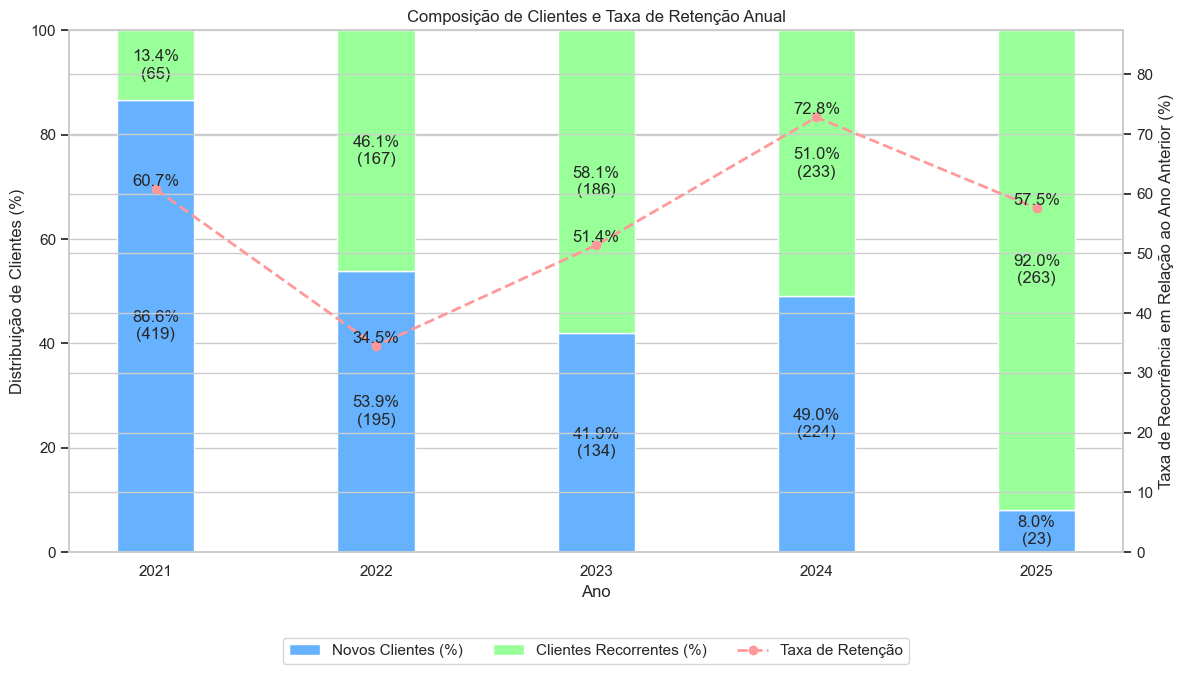


Resultados salvos em metricas_recorrencia_anual.xlsx

Métricas Anuais:
 ano  total_customers  returning_customers  new_customers  retention_rate  new_rate  returning_rate
2021              484                   65            419       60.747664 86.570248       13.429752
2022              362                  167            195       34.504132 53.867403       46.132597
2023              320                  186            134       51.381215 41.875000       58.125000
2024              457                  233            224       72.812500 49.015317       50.984683
2025              286                  263             23       57.549234  8.041958       91.958042

Estatísticas de Recorrência Anual:
Taxa média de retenção: 55.4%
Taxa média de novos clientes: 47.9%
Taxa média de recorrentes: 52.1%


In [73]:
# Criar ano para cada compra
merged_data['ano'] = merged_data['emissao_analise'].dt.to_period('Y')

# Criar DataFrame de clientes por ano
annual_customers = merged_data.groupby(['ano', 'id_cliente_analise']).size().reset_index()
annual_customers.columns = ['ano', 'id_cliente_analise', 'count']

# Criar pivot para análise anual
customer_matrix = annual_customers.pivot_table(
    index='id_cliente_analise',
    columns='ano',
    values='count',
    fill_value=0
).astype(bool).astype(int)

# Calcular métricas anuais
annual_metrics = []
years = sorted(customer_matrix.columns)

for i in range(1, len(years)):
    current_year = years[i]
    prev_year = years[i-1]
    
    # Total de clientes no ano anterior
    prev_customers = customer_matrix[prev_year].sum()
    
    # Clientes que voltaram
    returning = ((customer_matrix[prev_year] == 1) & (customer_matrix[current_year] == 1)).sum()
    
    # Novos clientes (não compraram no ano anterior)
    new_customers = (customer_matrix[current_year] & ~customer_matrix[prev_year]).sum()
    
    # Total de clientes no ano atual
    total_customers = customer_matrix[current_year].sum()
    
    # Calcular taxas
    retention_rate = (returning / prev_customers * 100) if prev_customers > 0 else 0
    new_rate = (new_customers / total_customers * 100) if total_customers > 0 else 0
    returning_rate = (returning / total_customers * 100) if total_customers > 0 else 0
    
    annual_metrics.append({
        'ano': str(current_year),
        'ano_obj': current_year,
        'total_customers': total_customers,
        'returning_customers': returning,
        'new_customers': new_customers,
        'retention_rate': retention_rate,  # Taxa de retenção em relação ao ano anterior
        'new_rate': new_rate,  # % de novos clientes no total
        'returning_rate': returning_rate  # % de clientes recorrentes no total
    })

annual_df = pd.DataFrame(annual_metrics)
annual_df = annual_df.sort_values('ano_obj')

# Visualização
plt.figure(figsize=(12, 7))  # Aumentado ligeiramente a altura para acomodar a legenda
ax1 = plt.gca()
x = np.arange(len(annual_df))
width = 0.35

# Plotar barras empilhadas com percentuais
bars1 = ax1.bar(x, annual_df['new_rate'], width, label='Novos Clientes (%)', color='#66B2FF')
bars2 = ax1.bar(x, annual_df['returning_rate'], width, bottom=annual_df['new_rate'],
                label='Clientes Recorrentes (%)', color='#99FF99')

# Plotar linha de retenção
ax2 = ax1.twinx()
line = ax2.plot(x, annual_df['retention_rate'], 'r--', label='Taxa de Retenção',
                color='#FF9999', linewidth=2, marker='o')

# Adicionar valores
for i in range(len(annual_df)):
    # Valores percentuais de novos clientes
    ax1.text(i, annual_df['new_rate'].iloc[i]/2,
             f'{annual_df["new_rate"].iloc[i]:.1f}%\n({annual_df["new_customers"].iloc[i]:,})',
             ha='center', va='center')
    
    # Valores percentuais de clientes recorrentes
    ax1.text(i, annual_df['new_rate'].iloc[i] + annual_df['returning_rate'].iloc[i]/2,
             f'{annual_df["returning_rate"].iloc[i]:.1f}%\n({annual_df["returning_customers"].iloc[i]:,})',
             ha='center', va='center')
    
    # Valores de taxa de retenção
    ax2.text(i, annual_df['retention_rate'].iloc[i],
             f'{annual_df["retention_rate"].iloc[i]:.1f}%',
             ha='center', va='bottom')

# Configurar eixos
ax1.set_xlabel('Ano')
ax1.set_ylabel('Distribuição de Clientes (%)')
ax2.set_ylabel('Taxa de Recorrência em Relação ao Ano Anterior (%)')

# Ajustar limites
ax1.set_ylim(0, 100)
ax2.set_ylim(0, max(annual_df['retention_rate']) * 1.2)

# Configurar ticks
plt.xticks(x, annual_df['ano'], rotation=45)

# Adicionar legendas fora do gráfico
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Posicionar a legenda abaixo do gráfico
ax1.legend(lines1 + lines2, labels1 + labels2, 
           bbox_to_anchor=(0.5, -0.15),  # Posição x, y da legenda
           loc='upper center',  # Ponto de ancoragem da legenda
           ncol=3,  # Número de colunas na legenda
           bbox_transform=ax1.transAxes)  # Usar coordenadas do eixo

plt.title('Composição de Clientes e Taxa de Retenção Anual')
plt.tight_layout()  # Ajustar layout para acomodar a legenda
plt.subplots_adjust(bottom=0.2)  # Ajustar espaço inferior para a legenda
plt.show()

# Salvar resultados
annual_df.to_excel('metricas_recorrencia_anual.xlsx', index=False)
print("\nResultados salvos em metricas_recorrencia_anual.xlsx")

# Imprimir estatísticas
print("\nMétricas Anuais:")
print(annual_df.drop('ano_obj', axis=1).to_string(index=False))

print("\nEstatísticas de Recorrência Anual:")
print(f"Taxa média de retenção: {annual_df['retention_rate'].mean():.1f}%")
print(f"Taxa média de novos clientes: {annual_df['new_rate'].mean():.1f}%")
print(f"Taxa média de recorrentes: {annual_df['returning_rate'].mean():.1f}%")

#### ANÁLISE DE RETENÇÃO POR SAFRAS DE CLIENTES

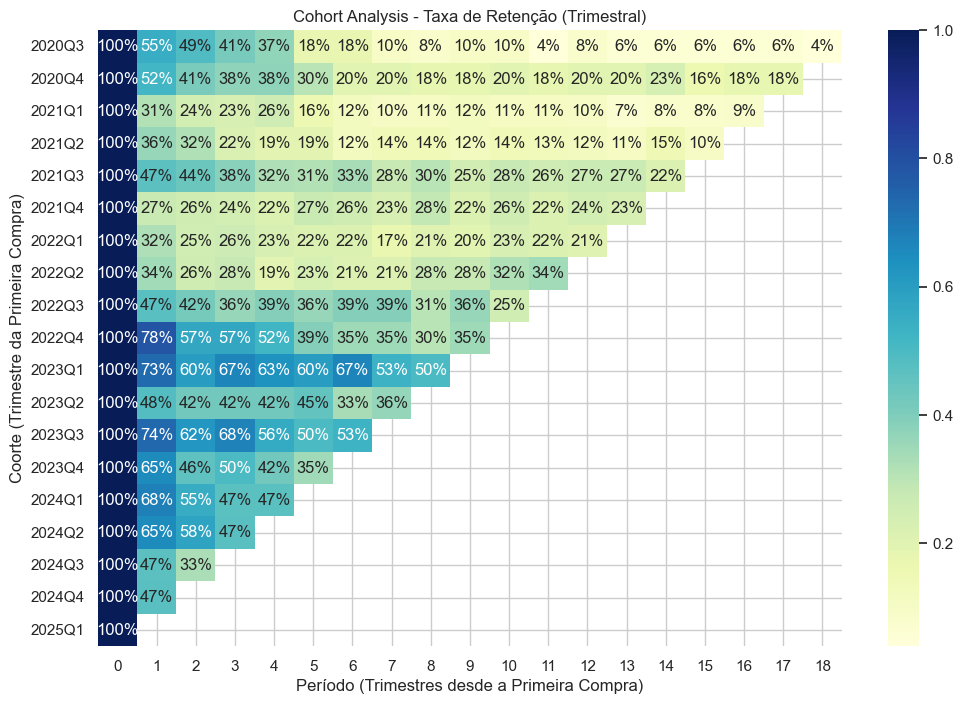

Tabela de Retenção por Coorte (Trimestral):
period_index     0         1         2         3         4         5   \
cohort_quarter                                                          
2020Q3          1.0  0.549020  0.490196  0.411765  0.372549  0.176471   
2020Q4          1.0  0.517857  0.410714  0.375000  0.375000  0.303571   
2021Q1          1.0  0.314286  0.242857  0.228571  0.257143  0.157143   
2021Q2          1.0  0.360000  0.320000  0.220000  0.190000  0.190000   
2021Q3          1.0  0.466667  0.438095  0.380952  0.323810  0.314286   
2021Q4          1.0  0.270270  0.256757  0.243243  0.216216  0.270270   
2022Q1          1.0  0.321839  0.252874  0.264368  0.229885  0.218391   
2022Q2          1.0  0.340426  0.255319  0.276596  0.191489  0.234043   
2022Q3          1.0  0.472222  0.416667  0.361111  0.388889  0.361111   
2022Q4          1.0  0.782609  0.565217  0.565217  0.521739  0.391304   
2023Q1          1.0  0.733333  0.600000  0.666667  0.633333  0.600000   
2023Q2 

In [74]:
# ---- Análise de Cohort: Agrupando Clientes em Coortes Trimestrais com Base na Primeira Compra ----

# Utilizaremos a base mesclada (merged_data) que já possui a coluna 'emissao_analise' em formato datetime.
# Cada pedido será associado a um período trimestral, e cada cliente receberá a coorte (trimestre) de sua primeira compra.

# 1. Definir o período do pedido como trimestre
merged_data['order_period'] = merged_data['emissao_analise'].dt.to_period('Q')

# 2. Para cada cliente, identificar a data da primeira compra e definir sua coorte trimestral
first_purchase = merged_data.groupby('id_cliente_analise')['emissao_analise'].min().reset_index()
first_purchase.columns = ['id_cliente_analise', 'first_purchase_date']
first_purchase['cohort_quarter'] = first_purchase['first_purchase_date'].dt.to_period('Q')

# 3. Mesclar a informação da coorte (trimestre da primeira compra) de volta à base de pedidos
merged_data = pd.merge(merged_data, first_purchase[['id_cliente_analise', 'cohort_quarter']], on='id_cliente_analise')

# 4. Calcular o índice do período (em trimestres) para cada pedido: quantos trimestres se passaram desde a coorte
# Se order_period e cohort_quarter forem do tipo Period, podemos subtraí-los diretamente
merged_data['period_index'] = (merged_data['order_period'] - merged_data['cohort_quarter']).apply(lambda x: x.n)

# 5. Agregar os dados para contar o número de clientes únicos por coorte e por período
cohort_data = merged_data.groupby(['cohort_quarter', 'period_index'])['id_cliente_analise'].nunique().reset_index()
cohort_data.rename(columns={'id_cliente_analise': 'num_customers'}, inplace=True)

# 6. Obter o tamanho inicial de cada coorte (ou seja, o número de clientes no período 0)
cohort_sizes = cohort_data[cohort_data['period_index'] == 0][['cohort_quarter', 'num_customers']]
cohort_sizes.rename(columns={'num_customers': 'cohort_size'}, inplace=True)

# 7. Mesclar o tamanho da coorte com os dados agregados
cohort_data = pd.merge(cohort_data, cohort_sizes, on='cohort_quarter')

# 8. Calcular a taxa de retenção para cada coorte e período:
#    Retention Rate = Número de clientes ativos no período / Tamanho inicial da coorte
cohort_data['retention_rate'] = cohort_data['num_customers'] / cohort_data['cohort_size']

# 9. Criar uma tabela dinâmica (pivot table) para visualizar a retenção ao longo dos trimestres
cohort_pivot = cohort_data.pivot(index='cohort_quarter', columns='period_index', values='retention_rate')

# 10. Plotar um mapa de calor para visualizar a evolução da retenção ao longo do tempo
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Cohort Analysis - Taxa de Retenção (Trimestral)')
plt.ylabel('Coorte (Trimestre da Primeira Compra)')
plt.xlabel('Período (Trimestres desde a Primeira Compra)')
plt.show()

# Exibir a tabela de retenção
print("Tabela de Retenção por Coorte (Trimestral):")
cohort_data.to_excel('metricas_retencao_trimestral.xlsx', index=False)
print(cohort_pivot)

<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
/var/folders/8y/5ndc5qwd1b38zpft_5ptb5280000gq/T/ipykernel_26869/1462132182.py:34: SyntaxWarning: invalid escape sequence '\d'
  cohort_data['cohort_year'] = cohort_data['cohort_year'].astype(str).str.extract('(\d+)').astype(int)


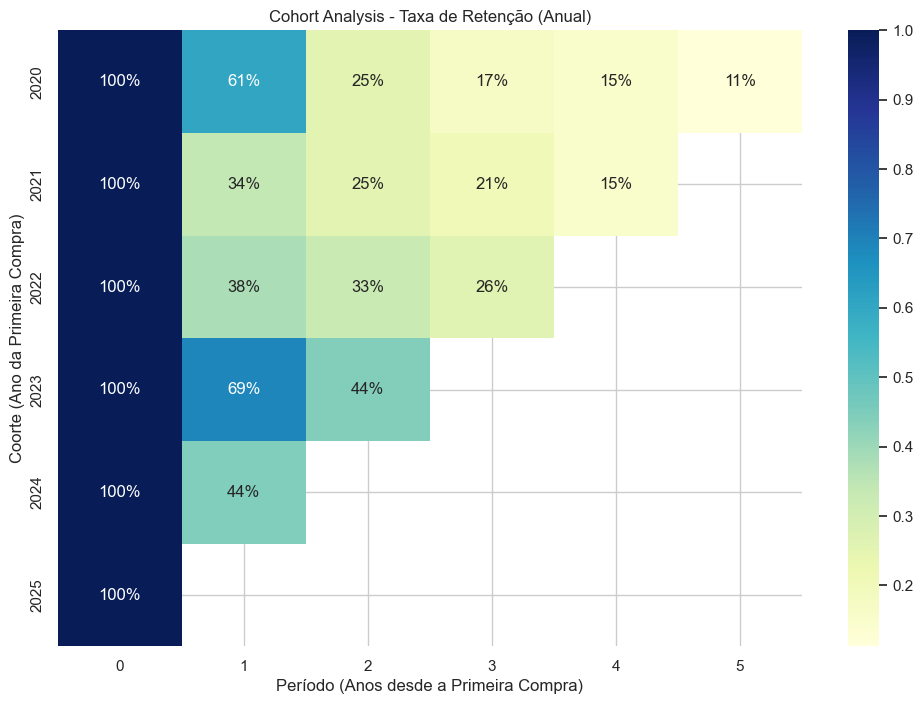

Tabela de Retenção por Coorte (Anual):
period_index    0         1         2         3         4        5
cohort_year                                                       
2020          1.0  0.607477  0.252336  0.168224  0.149533  0.11215
2021          1.0  0.338902  0.252983  0.207637  0.147971      NaN
2022          1.0  0.378238  0.326425  0.264249       NaN      NaN
2023          1.0  0.691057  0.439024       NaN       NaN      NaN
2024          1.0  0.441748       NaN       NaN       NaN      NaN
2025          1.0       NaN       NaN       NaN       NaN      NaN


In [75]:
# ---- Análise de Cohort: Agrupando Clientes em Coortes Anuais com Base na Primeira Compra ----

# Utilizaremos a base de dados df_vendas que já possui a coluna 'data_venda' no formato datetime.
# Cada pedido será associado a um período anual, e cada cliente receberá a coorte (ano) de sua primeira compra.

# 1. Definir o período do pedido como ano
merged_data['order_period'] = merged_data['emissao_analise'].dt.to_period('A')

# 2. Para cada cliente, identificar a data da primeira compra e definir sua coorte anual
first_purchase = merged_data.groupby('id_cliente_analise')['emissao_analise'].min().reset_index()
first_purchase.columns = ['id_cliente_analise', 'first_purchase_date']
first_purchase['cohort_year'] = first_purchase['first_purchase_date'].dt.to_period('A')

# 3. Mesclar a informação da coorte (ano da primeira compra) de volta à base de pedidos
merged_data = pd.merge(merged_data, first_purchase[['id_cliente_analise', 'cohort_year']], on='id_cliente_analise')

# 4. Calcular o índice do período (em anos) para cada pedido: quantos anos se passaram desde a coorte
merged_data['period_index'] = (merged_data['order_period'] - merged_data['cohort_year']).apply(lambda x: x.n)

# 5. Agregar os dados para contar o número de clientes únicos por coorte e por período
cohort_data = merged_data.groupby(['cohort_year', 'period_index'])['id_cliente_analise'].nunique().reset_index()
cohort_data.rename(columns={'id_cliente_analise': 'num_customers'}, inplace=True)

# 6. Obter o tamanho inicial de cada coorte (ou seja, o número de clientes no período 0)
cohort_sizes = cohort_data[cohort_data['period_index'] == 0][['cohort_year', 'num_customers']]
cohort_sizes.rename(columns={'num_customers': 'cohort_size'}, inplace=True)

# 7. Mesclar o tamanho da coorte com os dados agregados
cohort_data = pd.merge(cohort_data, cohort_sizes, on='cohort_year')

# 8. Calcular a taxa de retenção para cada coorte e período:
#    Taxa de Retenção = Número de clientes ativos no período / Tamanho inicial da coorte
cohort_data['retention_rate'] = cohort_data['num_customers'] / cohort_data['cohort_size']
cohort_data['cohort_year'] = cohort_data['cohort_year'].astype(str).str.extract('(\d+)').astype(int)

# 9. Criar uma tabela dinâmica (pivot table) para visualizar a retenção ao longo dos anos
cohort_pivot = cohort_data.pivot(index='cohort_year', columns='period_index', values='retention_rate')

# 10. Plotar um mapa de calor para visualizar a evolução da retenção ao longo do tempo
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Cohort Analysis - Taxa de Retenção (Anual)')
plt.ylabel('Coorte (Ano da Primeira Compra)')
plt.xlabel('Período (Anos desde a Primeira Compra)')
plt.show()

# Exibir a tabela de retenção
print("Tabela de Retenção por Coorte (Anual):")
cohort_data.to_excel('metricas_retencao_anual.xlsx', index=False)
print(cohort_pivot)

#### RFMA - ANÁLISE DE CLIENTES POR DECIS 

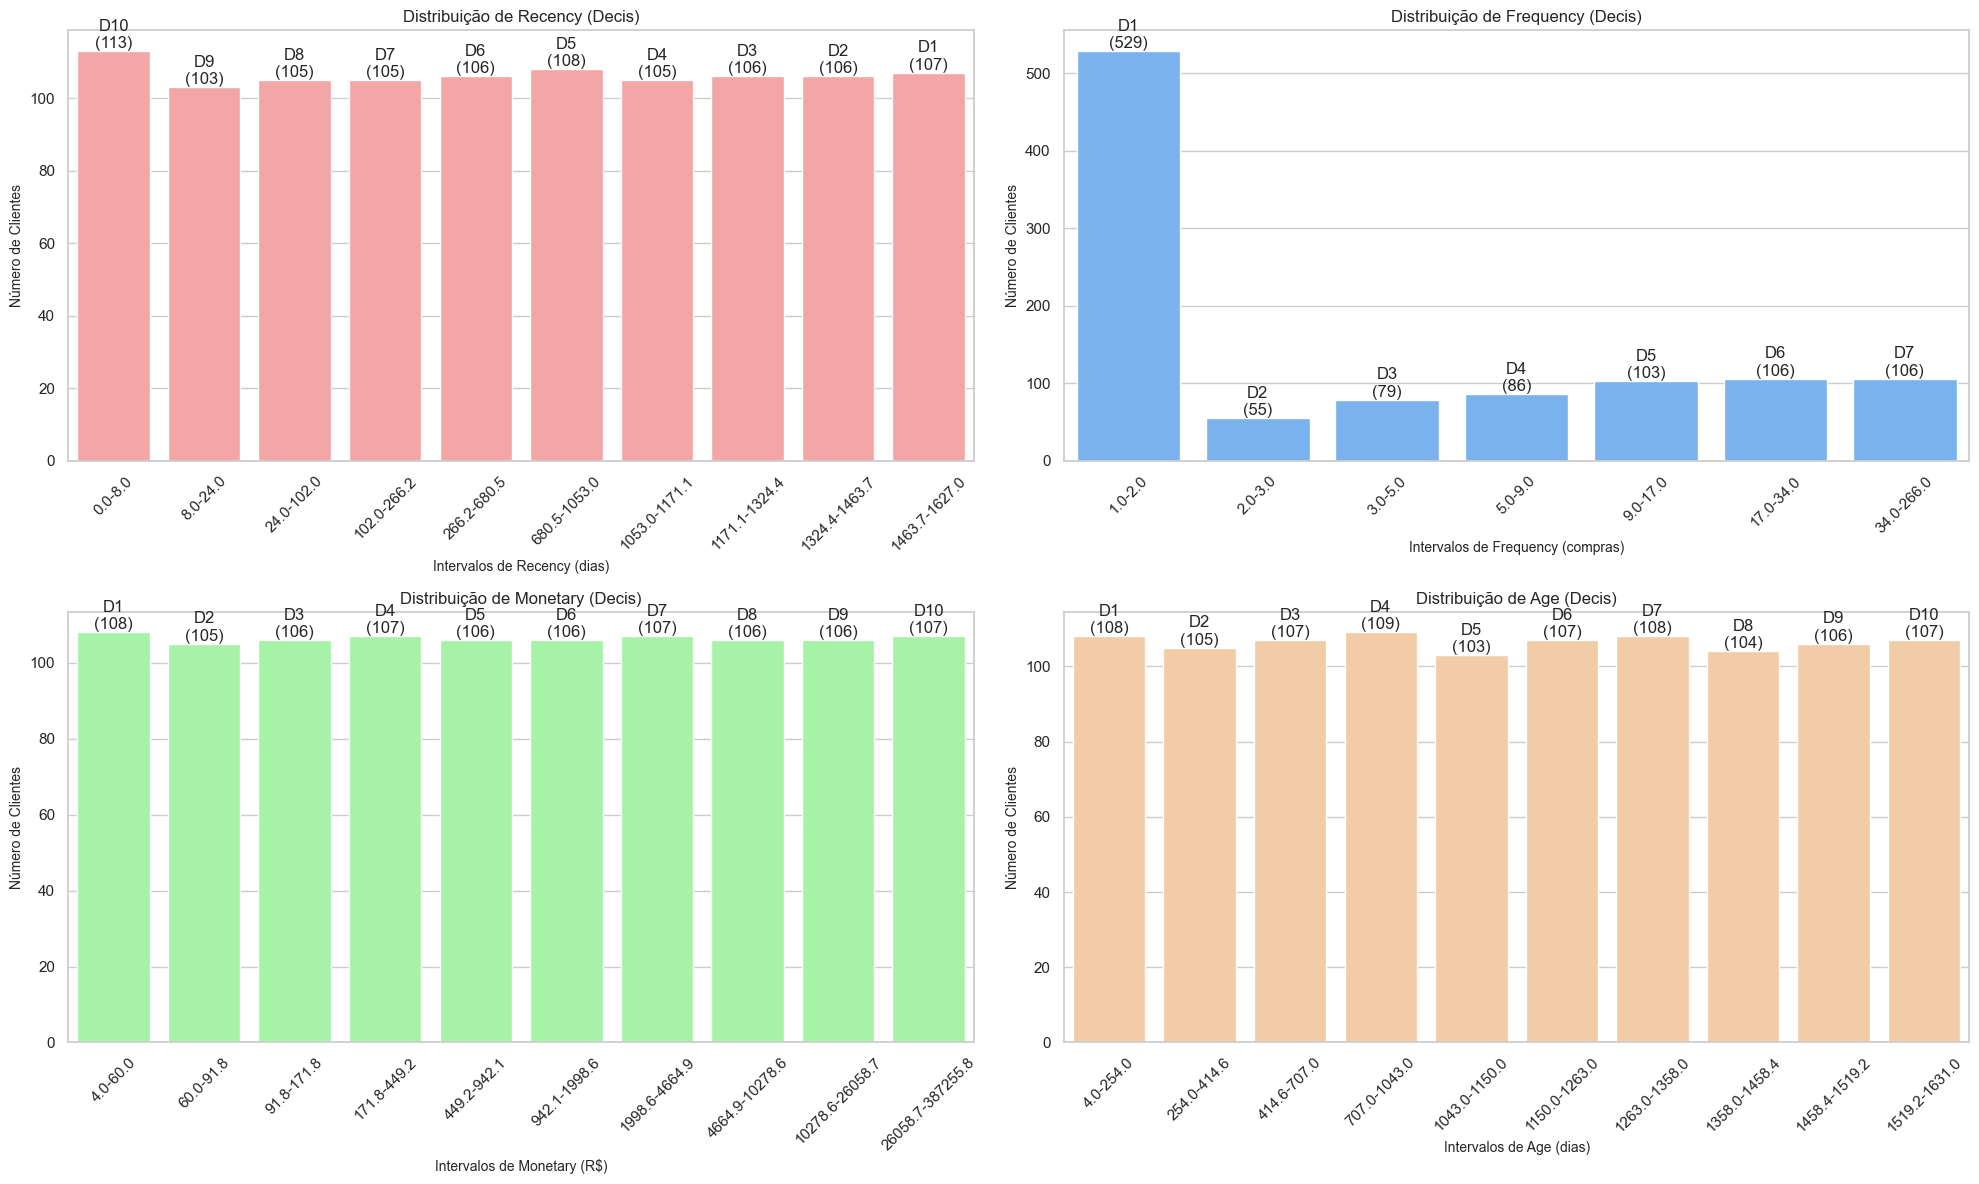


Exemplo dos primeiros registros com decis:
   Recency R_decil  Frequency F_decil  Monetary M_decil   Age A_decil
0     1115       4          4       3   1029.82       6  1622      10
1        1      10        266       7  34409.73      10  1631      10
2     1305       3          4       3   1406.00       6  1628      10
3     1255       3          4       3    653.98       5  1628      10
4     1627       1          1       1   2600.00       7  1627      10

Distribuição de clientes por faixa:

Recency (Ranges):
R_range
0.0-8.0          113
8.0-24.0         103
24.0-102.0       105
102.0-266.2      105
266.2-680.5      106
680.5-1053.0     108
1053.0-1171.1    105
1171.1-1324.4    106
1324.4-1463.7    106
1463.7-1627.0    107
Name: count, dtype: int64

Frequency (Ranges):
F_range
1.0-2.0       529
2.0-3.0        55
3.0-5.0        79
5.0-9.0        86
9.0-17.0      103
17.0-34.0     106
34.0-266.0    106
Name: count, dtype: int64

Monetary (Ranges):
M_range
4.0-60.0            108
60.

In [76]:
# Criar decis para cada métrica RFMA
# Primeiro vamos obter os bins para cada métrica
_, r_bins = pd.qcut(rfma['Recency'], q=10, duplicates='drop', retbins=True)
_, f_bins = pd.qcut(rfma['Frequency'], q=10, duplicates='drop', retbins=True)
_, m_bins = pd.qcut(rfma['Monetary'], q=10, duplicates='drop', retbins=True)
_, a_bins = pd.qcut(rfma['Age'], q=10, duplicates='drop', retbins=True)

# Agora criar os labels com o número correto de categorias
r_labels = list(range(len(r_bins)-1, 0, -1))  # Ordem inversa para Recency
f_labels = list(range(1, len(f_bins)))  # Ordem normal para os demais
m_labels = list(range(1, len(m_bins)))
a_labels = list(range(1, len(a_bins)))

# Aplicar os decis
rfma['R_decil'] = pd.qcut(rfma['Recency'], q=10, labels=r_labels, duplicates='drop')
rfma['F_decil'] = pd.qcut(rfma['Frequency'], q=10, labels=f_labels, duplicates='drop')
rfma['M_decil'] = pd.qcut(rfma['Monetary'], q=10, labels=m_labels, duplicates='drop')
rfma['A_decil'] = pd.qcut(rfma['Age'], q=10, labels=a_labels, duplicates='drop')

# Criar ranges para visualização
r_bins = pd.qcut(rfma['Recency'], q=10, duplicates="drop", retbins=True)[1]
rfma['R_range'] = pd.cut(
    rfma['Recency'], 
    bins=r_bins, 
    labels=[f"{r_bins[i]:.1f}-{r_bins[i+1]:.1f}" for i in range(len(r_bins)-1)], 
    include_lowest=True
)

f_bins = pd.qcut(rfma['Frequency'], q=10, duplicates="drop", retbins=True)[1]
rfma['F_range'] = pd.cut(
    rfma['Frequency'], 
    bins=f_bins, 
    labels=[f"{f_bins[i]:.1f}-{f_bins[i+1]:.1f}" for i in range(len(f_bins)-1)], 
    include_lowest=True
)

m_bins = pd.qcut(rfma['Monetary'], q=10, duplicates="drop", retbins=True)[1]
rfma['M_range'] = pd.cut(
    rfma['Monetary'], 
    bins=m_bins, 
    labels=[f"{m_bins[i]:.1f}-{m_bins[i+1]:.1f}" for i in range(len(m_bins)-1)], 
    include_lowest=True
)

a_bins = pd.qcut(rfma['Age'], q=10, duplicates="drop", retbins=True)[1]
rfma['A_range'] = pd.cut(
    rfma['Age'], 
    bins=a_bins, 
    labels=[f"{a_bins[i]:.1f}-{a_bins[i+1]:.1f}" for i in range(len(a_bins)-1)], 
    include_lowest=True
)

# Configurar estilo do gráfico
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Gráfico de Recency
r_counts = rfma['R_range'].value_counts().sort_index()
sns.barplot(x=r_counts.index, y=r_counts.values, ax=axes[0,0], color='#FF9999')
axes[0,0].set_title('Distribuição de Recency (Decis)', fontsize=12)
axes[0,0].set_xlabel('Intervalos de Recency (dias)', fontsize=10)
axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Recency
for i, v in enumerate(r_counts):
    decil = 10 - i  # Decil invertido para Recency
    axes[0,0].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Frequency
f_counts = rfma['F_range'].value_counts().sort_index()
sns.barplot(x=f_counts.index, y=f_counts.values, ax=axes[0,1], color='#66B2FF')
axes[0,1].set_title('Distribuição de Frequency (Decis)', fontsize=12)
axes[0,1].set_xlabel('Intervalos de Frequency (compras)', fontsize=10)
axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Frequency
for i, v in enumerate(f_counts):
    decil = i + 1
    axes[0,1].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Monetary
m_counts = rfma['M_range'].value_counts().sort_index()
sns.barplot(x=m_counts.index, y=m_counts.values, ax=axes[1,0], color='#99FF99')
axes[1,0].set_title('Distribuição de Monetary (Decis)', fontsize=12)
axes[1,0].set_xlabel('Intervalos de Monetary (R$)', fontsize=10)
axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
axes[1,0].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Monetary
for i, v in enumerate(m_counts):
    decil = i + 1
    axes[1,0].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

# Gráfico de Age (Antiguidade)
a_counts = rfma['A_range'].value_counts().sort_index()
sns.barplot(x=a_counts.index, y=a_counts.values, ax=axes[1,1], color='#FFCC99')
axes[1,1].set_title('Distribuição de Age (Decis)', fontsize=12)
axes[1,1].set_xlabel('Intervalos de Age (dias)', fontsize=10)
axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=45)

# Adicionar valores e decis no topo das barras de Age
for i, v in enumerate(a_counts):
    decil = i + 1
    axes[1,1].text(i, v, f'D{decil}\n({int(v)})', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Imprimir exemplo dos primeiros registros com os decis
print("\nExemplo dos primeiros registros com decis:")
print(rfma[['Recency', 'R_decil', 'Frequency', 'F_decil', 
            'Monetary', 'M_decil', 'Age', 'A_decil']].head())

# Imprimir distribuição
print("\nDistribuição de clientes por faixa:")
print("\nRecency (Ranges):")
print(r_counts)
print("\nFrequency (Ranges):")
print(f_counts)
print("\nMonetary (Ranges):")
print(m_counts)
print("\nAge (Ranges):")
print(a_counts)

#### RFMA - SEGMENTAÇÃO BASEADA EM REGRAS

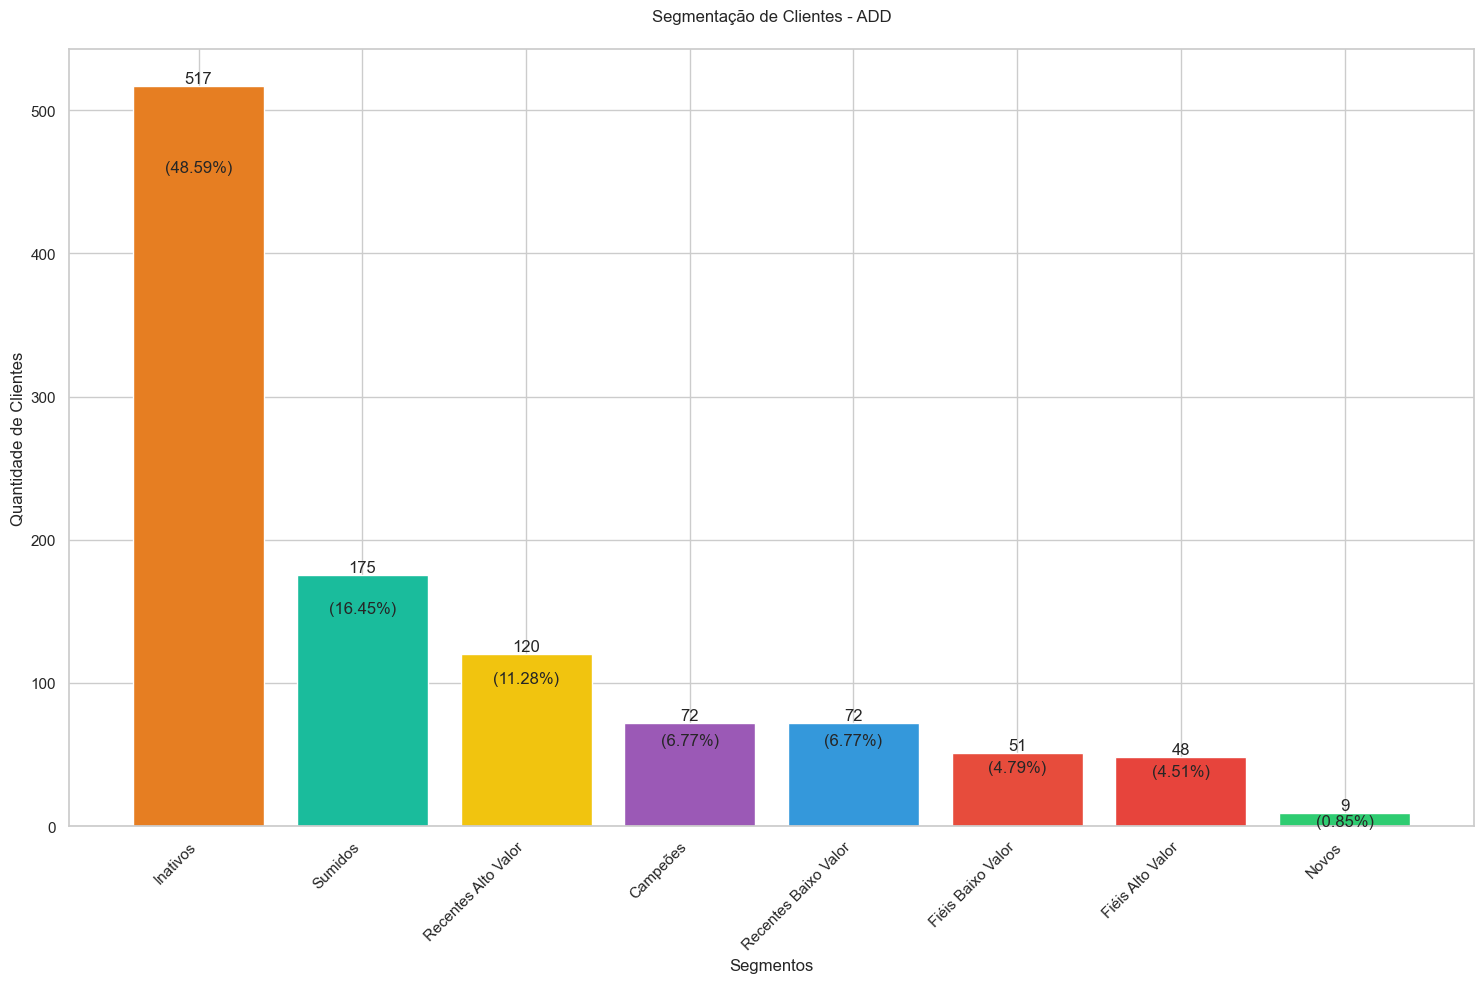


Análise Detalhada por Segmento:
                      Quantidade Clientes  Média Recency (dias)  \
Segmento                                                          
Inativos                              517               1254.25   
Sumidos                               175                398.86   
Recentes Alto Valor                   120                 35.05   
Campeões                               72                 11.74   
Recentes Baixo Valor                   72                 77.67   
Fiéis Baixo Valor                      51                 44.12   
Fiéis Alto Valor                       48                 30.06   
Novos                                   9                 14.22   

                      Média Frequency  Média Monetary (R$)  Média Age (dias)  
Segmento                                                                      
Inativos                         3.30              1333.30           1335.91  
Sumidos                         10.19              8559.81 

In [77]:
def segment_customers(df):
    """
    Segmenta clientes com base em regras atualizadas, de acordo com a análise da distribuição por faixa.
    
    Parâmetros:
    - Recency: dias desde a última compra
    - Age: dias desde a primeira compra (antiguidade)
    - Frequency: número de compras
    - Monetary: valor médio das compras
    """
    # Criar cópia do dataframe
    df_seg = df.copy()
    
    # Definir condições de forma mutuamente exclusiva

    cond_novos = (df_seg['Recency'] <= 30) & (df_seg['Age'] <= 30) # primeira compra no último mês

    cond_campeoes = (df_seg['Recency'] <= 180) & \
                    (df_seg['Frequency'] >= 34) & (df_seg['M_decil'] == 10) # clientes que compraram nos últimos 6 meses, possuem frequência de 37 ou mais e possuem valor monetário acima da média
                    
    cond_fieis_baixo_valor = (df_seg['Recency'] <= 180) & (df_seg['Age'] >= 730) & \
                 (df_seg['Frequency'] >= 4) & (df_seg['M_decil'] <= 8) # clientes há mais de 2 anos que compraram nos últimos 6 meses e possuem valor monetário menor ou igual a média
    
    cond_fieis_alto_valor = (df_seg['Recency'] <= 180) & (df_seg['Age'] >= 730) & \
                 (df_seg['Frequency'] >= 4) & (df_seg['M_decil'] > 8) # clientes há mais de 2 anos que compraram nos últimos 6 meses e possuem valor monetário acima da média
                 
    cond_recentes_alto = (df_seg['Recency'] <= 180) & \
                         (df_seg['Frequency'] >= 1) & (df_seg['M_decil'] > 6) # clientes que compraram nos últimos 6 meses e possui valor monetário acima da média
                         
    cond_recentes_baixo = (df_seg['Recency'] <= 180) & \
                          (df_seg['Frequency'] >= 1) & (df_seg['M_decil'] <= 6) # clientes que compraram nos últimos 6 meses e possui valor monetário abaixo da média
    
    # Clientes menos ativos
    cond_sumidos = (df_seg['Recency'] > 180) & (df_seg['Recency'] <= 730) # última compra entre 6 meses e 2 anos
    cond_inativos = (df_seg['Recency'] > 730) # sem comprar faz 2 anos
    
    # Lista de condições e respectivos rótulos
    conditions = [
        cond_novos,
        cond_campeoes,
        cond_fieis_baixo_valor,
        cond_fieis_alto_valor,
        cond_recentes_alto,
        cond_recentes_baixo,
        cond_sumidos,
        cond_inativos
    ]
    
    labels = [
        'Novos',
        'Campeões',
        'Fiéis Baixo Valor',
        'Fiéis Alto Valor',
        'Recentes Alto Valor',
        'Recentes Baixo Valor',
        'Sumidos',
        'Inativos'
    ]
    
    # Aplicar segmentação
    df_seg['Segmento'] = np.select(conditions, labels, default='Não Classificado')
    
    # Definir cores para cada segmento
    cores_segmento = {
        'Novos': '#2ecc71',               # Verde
        'Campeões': '#9b59b6',            # Roxo
        'Fiéis Baixo Valor': '#e74c3c',   # Vermelho
        'Fiéis Alto Valor' : '#e7443c',  
        'Recentes Alto Valor': '#f1c40f', # Amarelo
        'Recentes Baixo Valor': '#3498db',# Azul
        'Sumidos': '#1abc9c',             # Turquesa
        'Inativos': '#e67e22'             # Laranja
    }
    
    # Agregar dados para análise dos segmentos
    analise_segmentos = df_seg.groupby('Segmento').agg({
        'id_cliente_analise': 'count',
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Age': 'mean'
    }).round(2)
    
    analise_segmentos.columns = [
        'Quantidade Clientes',
        'Média Recency (dias)',
        'Média Frequency',
        'Média Monetary (R$)',
        'Média Age (dias)'
    ]
    
    # Ordenar por quantidade de clientes
    analise_segmentos = analise_segmentos.sort_values('Quantidade Clientes', ascending=False)
    
    # Visualização dos segmentos
    plt.figure(figsize=(15, 10))
    total_clientes = analise_segmentos['Quantidade Clientes'].sum()
    
    bars = plt.bar(
        analise_segmentos.index,
        analise_segmentos['Quantidade Clientes'],
        color=[cores_segmento.get(seg, '#95a5a6') for seg in analise_segmentos.index]
    )
    
    plt.title('Segmentação de Clientes - ADD', pad=20)
    plt.xlabel('Segmentos')
    plt.ylabel('Quantidade de Clientes')
    plt.xticks(rotation=45, ha='right')
    
    # Adicionar valores e porcentagens nas barras
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total_clientes) * 100
        
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{int(height):,}',
            ha='center',
            va='bottom'
        )
        
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height * 0.9,
            f'({percentage:.2f}%)',
            ha='center',
            va='top'
        )
    
    plt.tight_layout()
    plt.show()
    
    return df_seg, analise_segmentos

# Usar a função
rfma_segmentado, analise = segment_customers(rfma)

# Salvar resultados
# rfma_segmentado.to_excel('rfma_segmentado_regras.xlsx', index=False)
# print("\nResultados salvos em 'rfma_segmentado_regras.xlsx'")

# Exibir análise
print("\nAnálise Detalhada por Segmento:")
print("=" * 120)
print(analise)

#### RFMA - SEGMENTAÇÃO KMEANS - DECIS RFMA

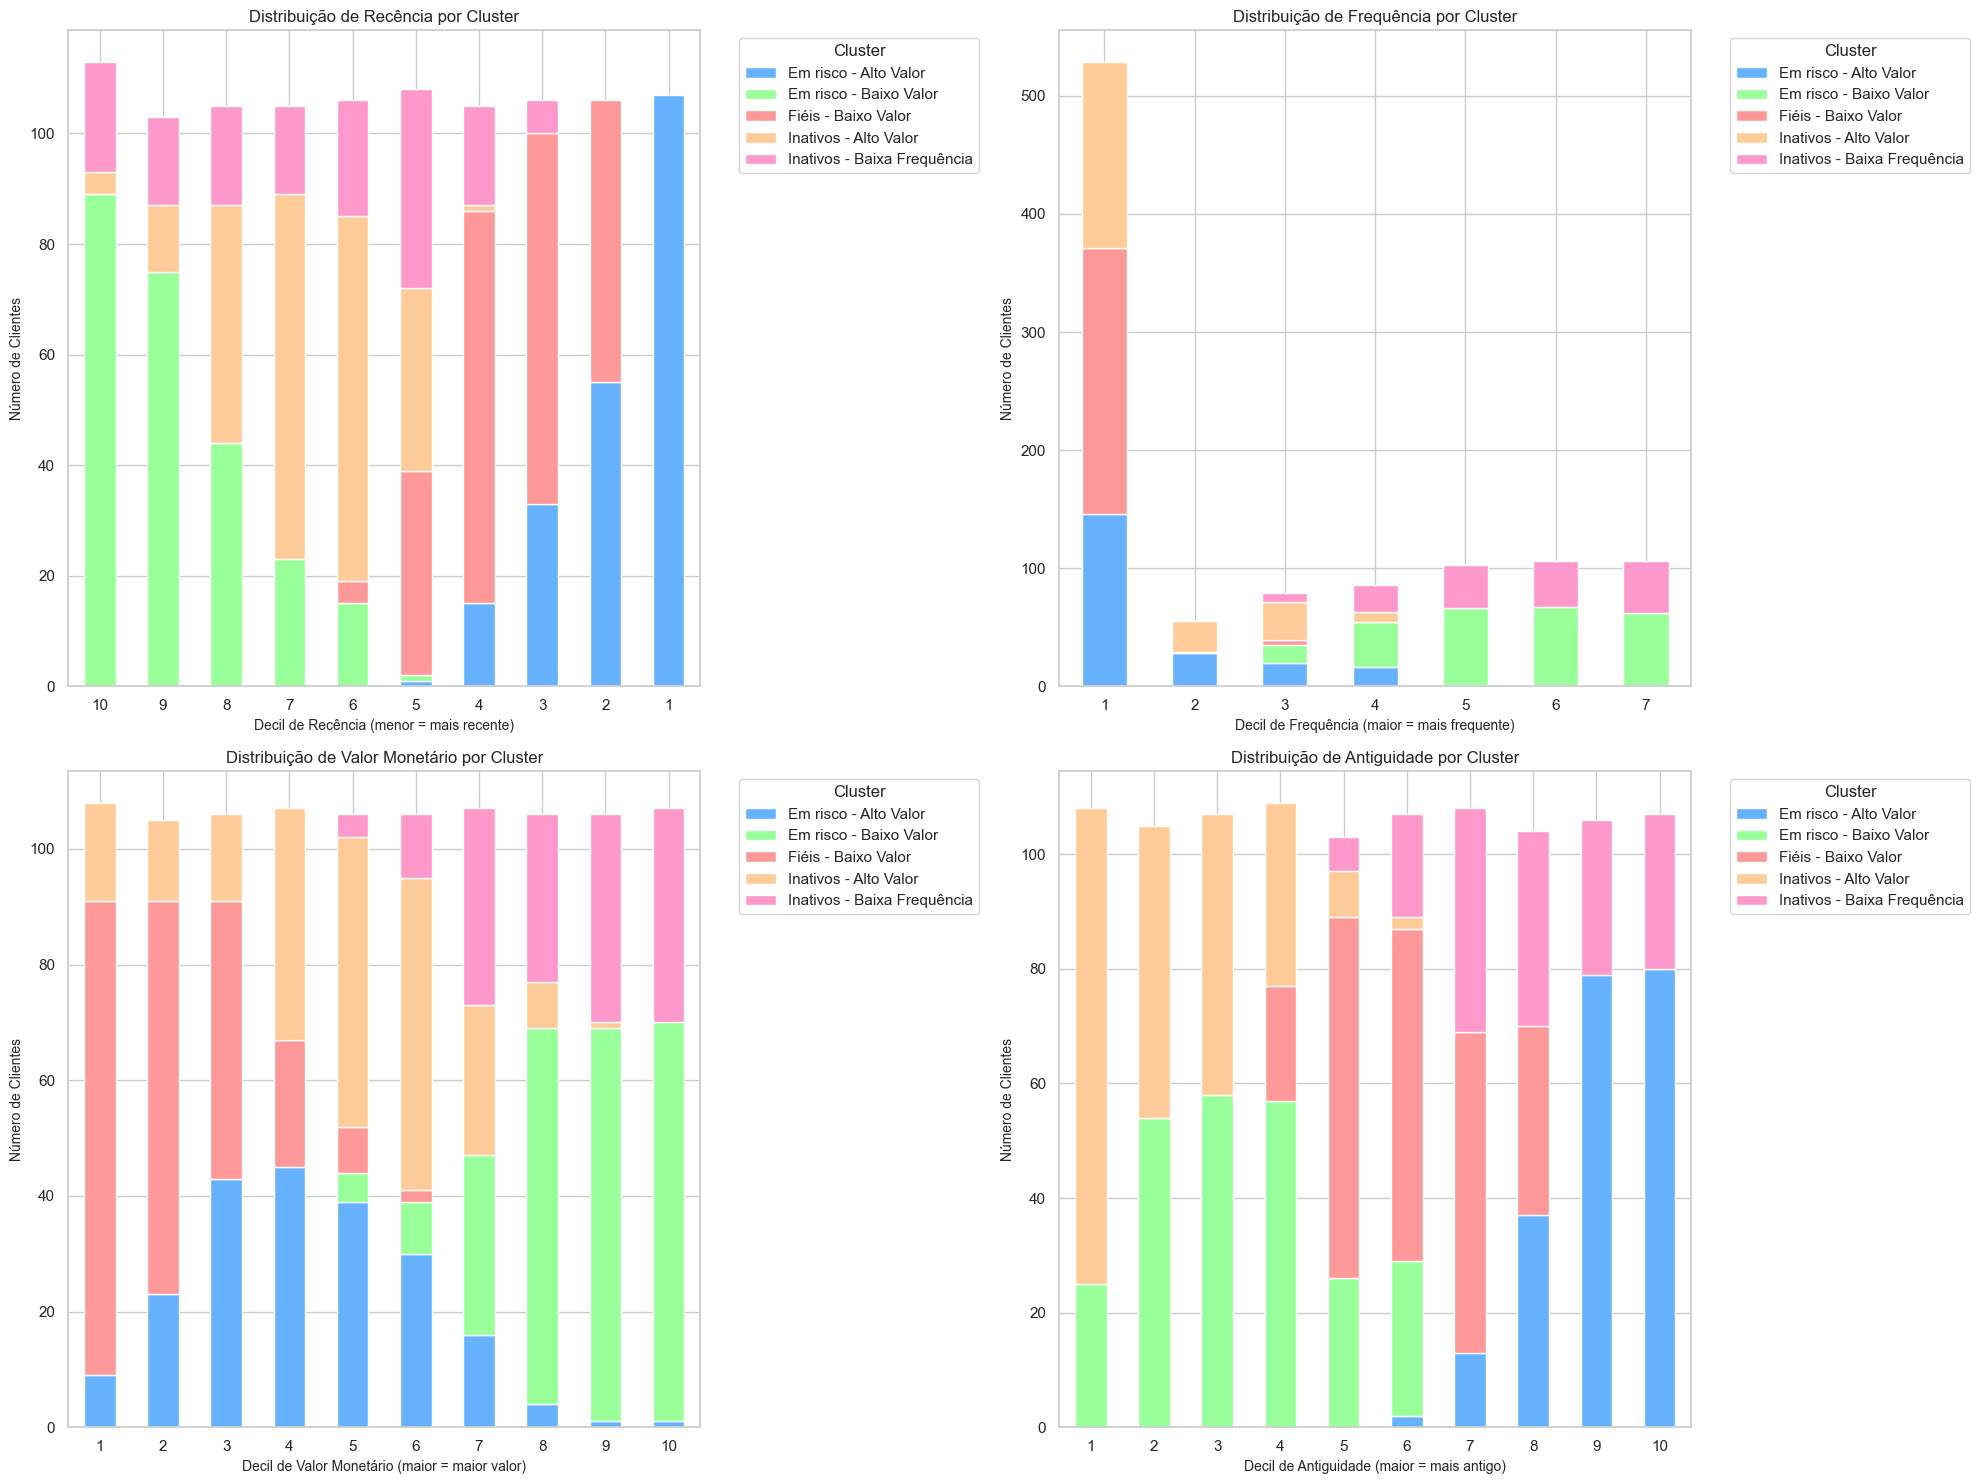


Distribuição detalhada por variável (Dados usados para LLM nomear os 5 Clusters:

Recência (menor = mais recente):
Cluster_Nome  Em risco - Alto Valor  Em risco - Baixo Valor  \
R_decil                                                       
10                                0                      89   
9                                 0                      75   
8                                 0                      44   
7                                 0                      23   
6                                 0                      15   
5                                 1                       1   
4                                15                       0   
3                                33                       0   
2                                55                       0   
1                               107                       0   

Cluster_Nome  Fiéis - Baixo Valor  Inativos - Alto Valor  \
R_decil                                                    
10     

In [78]:
# Preparar dados para clustering (usando os decis já calculados)
X = np.array([
    rfma['R_decil'].astype(int),
    rfma['F_decil'].astype(int),
    rfma['M_decil'].astype(int),
    rfma['A_decil'].astype(int)
]).T

# Realizar o clustering diretamente nos decis
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

# Adicionar clusters ao DataFrame original
rfma['Cluster'] = clusters

# Criar mapeamento de nomes dos clusters
cluster_names = {
    0: 'Fiéis - Baixo Valor',  # Compras recentes, baixo valor, alta antiguidade
    1: 'Inativos - Alto Valor', # Muito tempo sem comprar, alto valor
    2: 'Inativos - Baixa Frequência',  # Recentes mas já inativos, valor médio
    3: 'Em risco - Baixo Valor', # Valor baixo, reduzindo frequência
    4: 'Em risco - Alto Valor'        # Antigos, alto valor, começando a se afastar
}

# Mapear números dos clusters para nomes
rfma['Cluster_Nome'] = rfma['Cluster'].map(cluster_names)

# Criar gráficos de barra para RFMA por cluster
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Definir cores para os clusters
colors = ['#66B2FF', '#99FF99', '#FF9999', '#FFCC99', '#FF99CC']

# 1. Gráfico de Recência
r_cluster_counts = pd.crosstab(rfma['R_decil'], rfma['Cluster_Nome'])
r_cluster_counts.plot(kind='bar', stacked=True, ax=axes[0,0], color=colors)
axes[0,0].set_title('Distribuição de Recência por Cluster', fontsize=12)
axes[0,0].set_xlabel('Decil de Recência (menor = mais recente)', fontsize=10)
axes[0,0].set_ylabel('Número de Clientes', fontsize=10)
axes[0,0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,0].tick_params(axis='x', rotation=0)

# 2. Gráfico de Frequência
f_cluster_counts = pd.crosstab(rfma['F_decil'], rfma['Cluster_Nome'])
f_cluster_counts.plot(kind='bar', stacked=True, ax=axes[0,1], color=colors)
axes[0,1].set_title('Distribuição de Frequência por Cluster', fontsize=12)
axes[0,1].set_xlabel('Decil de Frequência (maior = mais frequente)', fontsize=10)
axes[0,1].set_ylabel('Número de Clientes', fontsize=10)
axes[0,1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].tick_params(axis='x', rotation=0)

# 3. Gráfico de Valor Monetário
m_cluster_counts = pd.crosstab(rfma['M_decil'], rfma['Cluster_Nome'])
m_cluster_counts.plot(kind='bar', stacked=True, ax=axes[1,0], color=colors)
axes[1,0].set_title('Distribuição de Valor Monetário por Cluster', fontsize=12)
axes[1,0].set_xlabel('Decil de Valor Monetário (maior = maior valor)', fontsize=10)
axes[1,0].set_ylabel('Número de Clientes', fontsize=10)
axes[1,0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Gráfico de Antiguidade
a_cluster_counts = pd.crosstab(rfma['A_decil'], rfma['Cluster_Nome'])
a_cluster_counts.plot(kind='bar', stacked=True, ax=axes[1,1], color=colors)
axes[1,1].set_title('Distribuição de Antiguidade por Cluster', fontsize=12)
axes[1,1].set_xlabel('Decil de Antiguidade (maior = mais antigo)', fontsize=10)
axes[1,1].set_ylabel('Número de Clientes', fontsize=10)
axes[1,1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Imprimir as contagens para cada combinação de decil e cluster
print("\nDistribuição detalhada por variável (Dados usados para LLM nomear os 5 Clusters:")
print("\nRecência (menor = mais recente):")
print(r_cluster_counts)
print("\nFrequência (maior = mais frequente):")
print(f_cluster_counts)
print("\nValor Monetário (maior = maior valor):")
print(m_cluster_counts)
print("\nAntiguidade (maior = mais antigo):")
print(a_cluster_counts)


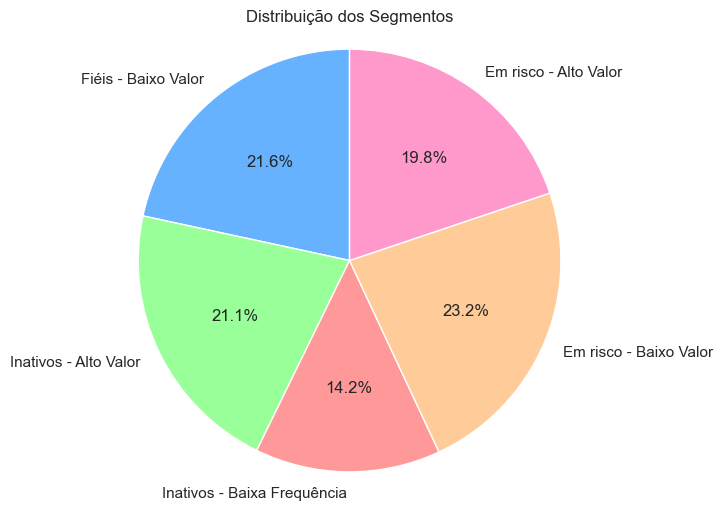

In [79]:
# Contar o número de clientes por cluster (usando a coluna de nomes dos clusters)
cluster_counts = rfma['Cluster'].value_counts().sort_index()

# Criar lista de labels (nomes dos clusters) na mesma ordem dos índices
labels = [cluster_names[i] for i in sorted(cluster_names.keys())]

# Definir as cores para cada segmento (na mesma ordem dos clusters)
pie_colors = ['#66B2FF', '#99FF99', '#FF9999', '#FFCC99', '#FF99CC']

# Criar o gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(cluster_counts, labels=labels, autopct='%1.1f%%', colors=pie_colors, startangle=90)
plt.title('Distribuição dos Segmentos')
plt.axis('equal')  # Garante que o gráfico fique em formato circular
plt.show()


#### Preparando dados para o Dashboard da ADD

In [80]:
final_analytics = pd.merge(
    rfma,
    rfma_segmentado[['id_cliente_analise', 'Segmento']],
    on='id_cliente_analise',
    how='left'
)

# (Opcional) Reorganize as colunas conforme sua necessidade para o analytics:
colunas_ordenadas = [
    'id_cliente_analise', 'Recency', 'Frequency', 'Monetary', 'Age',
    'R_decil', 'F_decil', 'M_decil', 'A_decil',
    'R_range', 'F_range', 'M_range', 'A_range',
    'Segmento', 'Cluster', 'Cluster_Nome'
]
final_analytics = final_analytics[colunas_ordenadas]

# Renomear a coluna 'cliente_id' para 'id_cliente' para realizar De_para
final_analytics.rename(columns={'id_cliente_analise': 'id_cliente'}, inplace=True)

df_de_para = pd.read_excel('De_para_Clientes_2024_12_22.xlsx')

df_merged = pd.merge(final_analytics, df_de_para, on='id_cliente', how='left')

#Arquivo usado para o dash de segmentação
df_merged.to_csv('analytics_cliente_ADD.csv', index=False)

print("Merge concluído. Arquivo salvo como 'analytics_cliente_ADD.csv'.")

Merge concluído. Arquivo salvo como 'analytics_cliente_ADD.csv'.


#### PREDIÇÃO DE COMPRAS POR CLIENTE NOS PRÓXIMOS 30 DIAS

Optimization terminated successfully.
         Current function value: -90.602014
         Iterations: 18
         Function evaluations: 21
         Gradient evaluations: 21

Parâmetros do Modelo:
<lifetimes.BetaGeoFitter: fitted with 482 subjects, a: 0.16, alpha: 31.96, b: 2.02, r: 1.35>

Estatísticas das Previsões:
count    4.720000e+02
mean     7.290966e-01
std      9.270147e-01
min      2.342258e-17
25%      5.326493e-03
50%      4.391972e-01
75%      9.870909e-01
max      4.357399e+00
Name: predicted_purchases_30d, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lifetimes/fitters/__init__.py:101: OptimizeWarning: Unknown solver options: iterative_fitting
  output = minimize(


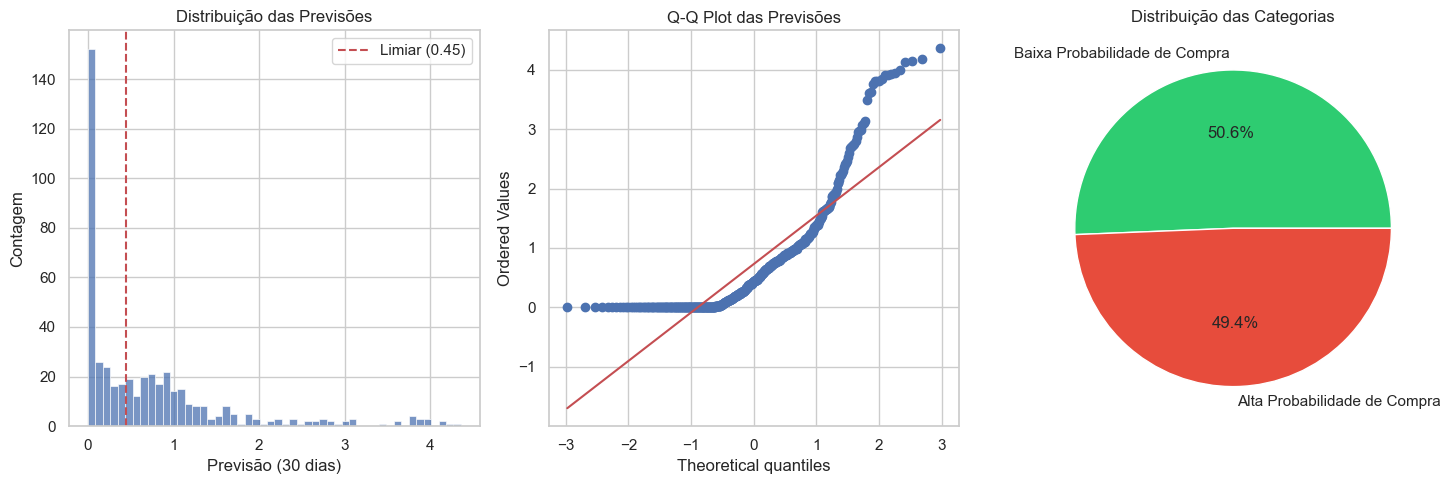


Análise por Categoria de Previsão:
                              Frequency              Recency        Monetary  \
                                   mean median count    mean median     mean   
categoria_previsao                                                             
Alta Probabilidade de Compra      37.88   27.0   233   19.08   14.0  33287.9   
Baixa Probabilidade de Compra     14.17    8.0   239  581.57  457.0  10876.8   

                                        predicted_purchases_30d               \
                                 median                    mean median   min   
categoria_previsao                                                             
Alta Probabilidade de Compra   14723.11                    1.38   0.99  0.45   
Baixa Probabilidade de Compra   3752.45                    0.10   0.01  0.00   

                                     
                                max  
categoria_previsao                   
Alta Probabilidade de Compra   4.36  
Baixa Prob

In [81]:
# Pré-processamento para o modelo BG/NBD
rfma = df_merged.copy()

# Limpeza e tratamento dos dados
rfma = rfma[rfma['Frequency'] > 3]

# Ajustar os valores para evitar problemas numéricos
rfma['frequency_adjusted'] = rfma['Frequency'] - 1
rfma['recency_bg'] = (rfma['Age'] - rfma['Recency']).clip(lower=1)  # Garantir valores positivos
rfma['T'] = rfma['Age'].clip(lower=1)  # Garantir valores positivos

# Remover outliers extremos
for col in ['frequency_adjusted', 'recency_bg', 'T']:
    Q1 = rfma[col].quantile(0.01)
    Q3 = rfma[col].quantile(0.99)
    IQR = Q3 - Q1
    rfma = rfma[
        (rfma[col] >= Q1 - 1.5 * IQR) &
        (rfma[col] <= Q3 + 1.5 * IQR)
    ]

# Ajuste do Modelo BG/NBD com parâmetros para melhor convergência
bgf = BetaGeoFitter(penalizer_coef=0.01)  # Aumentar penalizador
bgf.fit(
    rfma['frequency_adjusted'],
    rfma['recency_bg'],
    rfma['T'],
    iterative_fitting=2,          # Reduzir número de iterações
    tol=1e-4,                     # Aumentar tolerância
    initial_params=None,          # Permitir estimativa automática
    verbose=True                  # Mostrar progresso
)

# Calcular previsões para 30 dias
rfma['predicted_purchases_30d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30,
    rfma['frequency_adjusted'],
    rfma['recency_bg'],
    rfma['T']
)

# Remover previsões extremas ou inválidas
rfma = rfma[rfma['predicted_purchases_30d'].between(
    rfma['predicted_purchases_30d'].quantile(0.01),
    rfma['predicted_purchases_30d'].quantile(0.99)
)]

# Imprimir parâmetros do modelo
print("\nParâmetros do Modelo:")
print(bgf)
print("\nEstatísticas das Previsões:")
print(rfma['predicted_purchases_30d'].describe())

# Definir limiar usando método mais robusto
limiar = rfma['predicted_purchases_30d'].median() + \
         rfma['predicted_purchases_30d'].std() * 0.01

# Classificar clientes
rfma['categoria_previsao'] = np.where(
    rfma['predicted_purchases_30d'] >= limiar,
    'Alta Probabilidade de Compra',
    'Baixa Probabilidade de Compra'
)

# Visualizações
plt.figure(figsize=(15, 5))

# 1. Distribuição das Previsões
plt.subplot(1, 3, 1)
sns.histplot(data=rfma, x='predicted_purchases_30d', bins=50)
plt.axvline(x=limiar, color='r', linestyle='--', label=f'Limiar ({limiar:.2f})')
plt.title('Distribuição das Previsões')
plt.xlabel('Previsão (30 dias)')
plt.ylabel('Contagem')
plt.legend()

# 2. QQ-Plot para verificar normalidade
plt.subplot(1, 3, 2)
from scipy.stats import probplot
probplot(rfma['predicted_purchases_30d'], dist="norm", plot=plt)
plt.title('Q-Q Plot das Previsões')

# 3. Contagem por Categoria
plt.subplot(1, 3, 3)
contagem = rfma['categoria_previsao'].value_counts()
plt.pie(contagem, labels=contagem.index, autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'])
plt.title('Distribuição das Categorias')

plt.tight_layout()
plt.show()

# Análise por categoria
print("\nAnálise por Categoria de Previsão:")
analise_categoria = rfma.groupby('categoria_previsao').agg({
    'Frequency': ['mean', 'median', 'count'],
    'Recency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'predicted_purchases_30d': ['mean', 'median', 'min', 'max']
}).round(2)

print(analise_categoria)

# Validação das previsões
print("\nValidação do Modelo:")
print(f"Média de transações previstas: {rfma['predicted_purchases_30d'].mean():.2f}")
print(f"Mediana de transações previstas: {rfma['predicted_purchases_30d'].median():.2f}")
print(f"% de clientes com alta probabilidade: {(rfma['categoria_previsao'] == 'Alta Probabilidade de Compra').mean()*100:.1f}%")

# Salvar resultados
rfma.to_excel('rfma_previsoes_ajustado.xlsx', index=False)
print("\nResultados salvos em 'rfma_previsoes_ajustado.xlsx'")

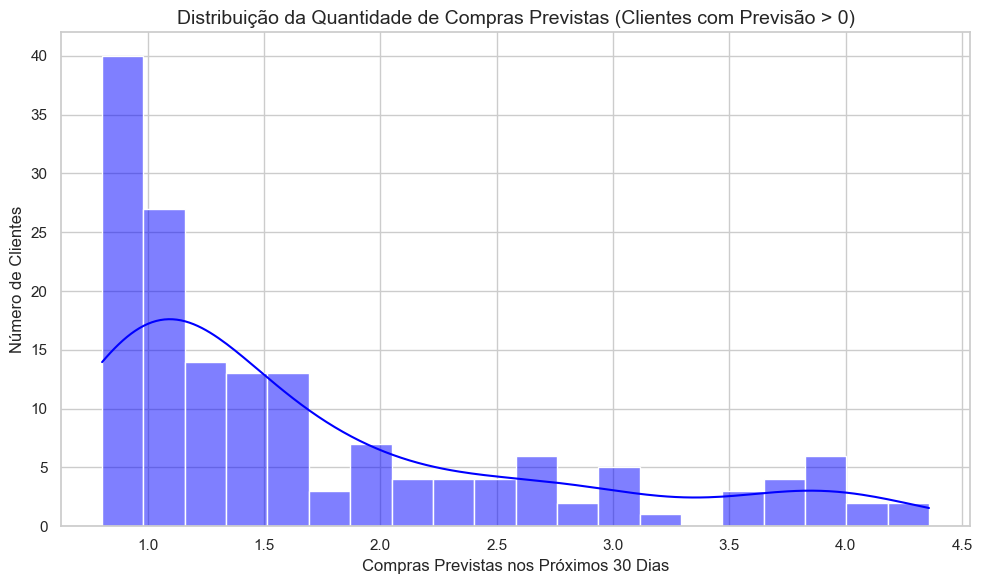

In [82]:
# Filtrar os clientes com previsão de compras > 0 utilizando .loc para garantir que uma Series seja retornada
dados = rfma.loc[rfma['predicted_purchases_30d'] > 0.8, 'predicted_purchases_30d']
plt.figure(figsize=(10, 6))
# Se o parâmetro edgecolor continuar causando problemas, remova-o:
sns.histplot(dados, bins=20, kde=True, color='blue')
# Caso deseje usar edgecolor, tente:
# sns.histplot(dados, bins=20, kde=True, color='blue', edgecolor='k')
plt.title('Distribuição da Quantidade de Compras Previstas (Clientes com Previsão > 0)', fontsize=14)
plt.xlabel('Compras Previstas nos Próximos 30 Dias', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.tight_layout()
plt.show()